In [1]:
import pickle
import yaml

import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import floor
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import spearmanr
from decimal import Decimal

from carot.utils import get_source_target_transport, score_transports_and_targets_combinations
from cmonge.utils import load_config
from carot.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from carot.datasets.conditional_loader import ConditionalDataModule

In [2]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

ot_colors = {
    "blue": "#648FFF",
    "purple": "#785EF0",
    "pink": "#DC267F",
    "orange": "#FE6100",
    "yellow": "#FFB000",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "CAROT": default_colors["cyan"],
    "conCAROT": default_colors["indigo"],
    "within condition": default_colors["green"],
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": ot_colors["blue"],
    "target": ot_colors["pink"],
    "transport": ot_colors["yellow"],
    "rest": ot_colors["grey"]
}


In [3]:
sns.set(font="Arial")
sns.set_context("paper")
sns.set_style("whitegrid")
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ytick.left'] = True
mpl.rcParams['xtick.bottom'] = True

In [4]:
with open("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CD8_sel_cars.txt") as f:
    CD8_sel_cars = f.readlines()
with open("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CD4_sel_cars.txt") as f:
    CD4_sel_cars = f.readlines()
CD8_sel_cars = [c[:-1] for c in CD8_sel_cars]
CD4_sel_cars = [c[:-1] for c in CD4_sel_cars]

sel_cars = {"CD8": CD8_sel_cars, "CD4": CD4_sel_cars}

In [5]:
features = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/functional_and_score_genes.txt"

logger_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/logger.json"
base_config_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_ckpt_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
base_fig_save = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Figures/cmonge/Score_dist_comparison/sel_CARs"

In [6]:
expr_list = []
meta_list = []
for subset in ["CD4", "CD8"]:
    adata = sc.read_h5ad(f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad")
    config_path = f"{base_config_path}{subset}_esm_XL_tail_dim_FuncScore/config.yaml"
    config = load_config(config_path)
    config.model.checkpointing_path = f"{base_ckpt_path}{subset}_esm_XL_tail_dim_FuncScore/model"
    config.data.file_path = f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/{subset}.h5ad"
    config.data.features = features
    config.data.drugs_path = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CAR_variants.txt"
    config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

    for car in adata.obs["CAR_Variant"].unique():
        if car in ["NA-NA-NA", "NA-NA-z"]:
            continue
        print(car)
        batch_size = min(sum(adata.obs["CAR_Variant"]==car), sum(adata.obs["CAR_Variant"]=="NA-NA-NA"))
        batch_size = floor(batch_size * config.data.split[1])
        config.data.batch_size=batch_size
        config.condition.conditions = [car]
        config.model.embedding.model_dir = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/embedding/"

        datamodule = ConditionalDataModule(config.data, config.condition, config.ae)
        trainer = ConditionalMongeTrainer.load_checkpoint(
            jobid=1,
            logger_path=logger_path, 
            config=config.model, 
            datamodule=datamodule, 
            ckpt_path=config.model.checkpointing_path
            )
    
        all_expr, all_meta = get_source_target_transport(datamodule=datamodule, 
                                                         trainer=trainer,
                                                         conditions=[car])
        expr_list.append(all_expr)
        meta_list.append(all_meta)

41BB-41BB-z


2025-09-23 19:57:36.561 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-09-23 19:57:36.831 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:36.979 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (746,), valid: (187,), test: (0,).
2025-09-23 19:57:36.979 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:36.979 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:36.979 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:38.068 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-CD28-z


2025-09-23 19:57:39.099 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-09-23 19:57:39.365 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:39.371 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1085,), valid: (272,), test: (0,).
2025-09-23 19:57:39.371 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:39.371 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:39.371 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:39.395 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-CD40-z


2025-09-23 19:57:39.811 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-09-23 19:57:40.079 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:40.084 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (776,), valid: (195,), test: (0,).
2025-09-23 19:57:40.085 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:40.085 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:40.085 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:40.108 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-CTLA4-z


2025-09-23 19:57:40.445 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-09-23 19:57:40.637 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:40.642 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (248,), valid: (63,), test: (0,).
2025-09-23 19:57:40.643 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:40.643 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:40.643 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:40.664 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(62, 5120)
41BB-IL15RA-z


2025-09-23 19:57:41.519 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-09-23 19:57:41.733 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:41.739 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (840,), valid: (211,), test: (0,).
2025-09-23 19:57:41.739 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:41.739 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:41.740 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:41.763 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-NA-z


2025-09-23 19:57:42.185 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-09-23 19:57:42.446 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:42.451 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (765,), valid: (192,), test: (0,).
2025-09-23 19:57:42.451 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:42.451 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:42.452 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:42.473 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-41BB-z


2025-09-23 19:57:42.898 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-09-23 19:57:43.164 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:43.169 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (172,), valid: (43,), test: (0,).
2025-09-23 19:57:43.169 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:43.169 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:43.170 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:43.192 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(43, 5120)
CD28-CD28-z


2025-09-23 19:57:44.190 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-09-23 19:57:44.472 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:44.478 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (833,), valid: (209,), test: (0,).
2025-09-23 19:57:44.478 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:44.478 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:44.479 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:44.499 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-CD40-z


2025-09-23 19:57:44.964 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-09-23 19:57:45.404 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:45.410 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (818,), valid: (205,), test: (0,).
2025-09-23 19:57:45.411 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:45.411 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:45.411 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:45.435 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-CTLA4-z


2025-09-23 19:57:45.917 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-09-23 19:57:46.377 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:46.382 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (214,), valid: (54,), test: (0,).
2025-09-23 19:57:46.383 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:46.383 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:46.383 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:46.405 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(53, 5120)
CD28-IL15RA-z


2025-09-23 19:57:47.458 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-09-23 19:57:47.956 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:47.962 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1153,), valid: (289,), test: (0,).
2025-09-23 19:57:47.962 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:47.962 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:47.962 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:47.985 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD28-NA-z


2025-09-23 19:57:48.460 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-09-23 19:57:48.908 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:48.917 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1145,), valid: (287,), test: (0,).
2025-09-23 19:57:48.917 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:48.917 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:48.917 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:48.951 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD40-41BB-z


2025-09-23 19:57:49.385 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-09-23 19:57:49.869 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:49.874 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (556,), valid: (140,), test: (0,).
2025-09-23 19:57:49.874 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:49.874 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:49.875 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:49.896 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(139, 5120)
CD40-CD28-z


2025-09-23 19:57:50.917 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-09-23 19:57:51.412 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:51.424 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (590,), valid: (148,), test: (0,).
2025-09-23 19:57:51.424 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:51.424 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:51.424 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:51.451 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(147, 5120)
CD40-CD40-z


2025-09-23 19:57:52.482 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-09-23 19:57:52.977 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:52.983 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (542,), valid: (136,), test: (0,).
2025-09-23 19:57:52.984 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:52.984 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:52.984 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:53.010 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(135, 5120)
CD40-CTLA4-z


2025-09-23 19:57:54.020 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-09-23 19:57:54.506 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:54.512 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (259,), valid: (65,), test: (0,).
2025-09-23 19:57:54.513 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:54.513 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:54.513 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:54.536 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(64, 5120)
CD40-IL15RA-z


2025-09-23 19:57:55.546 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-09-23 19:57:56.061 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:56.067 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (645,), valid: (162,), test: (0,).
2025-09-23 19:57:56.067 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:56.068 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:56.068 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:56.100 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CD40-NA-z


2025-09-23 19:57:56.499 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-09-23 19:57:57.009 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:57.015 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (794,), valid: (199,), test: (0,).
2025-09-23 19:57:57.015 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:57.015 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:57.016 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:57.037 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
CTLA4-41BB-z


2025-09-23 19:57:57.445 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-09-23 19:57:57.960 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:57.966 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (188,), valid: (48,), test: (0,).
2025-09-23 19:57:57.966 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:57.966 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:57.967 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:57.989 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(47, 5120)
CTLA4-CD28-z


2025-09-23 19:57:59.036 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-09-23 19:57:59.499 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:57:59.505 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (452,), valid: (113,), test: (0,).
2025-09-23 19:57:59.505 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:57:59.506 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:57:59.506 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:57:59.535 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(113, 5120)
CTLA4-CD40-z


2025-09-23 19:58:00.608 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-09-23 19:58:01.105 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:58:01.111 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (162,), valid: (41,), test: (0,).
2025-09-23 19:58:01.111 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:58:01.112 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:58:01.112 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:58:01.138 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(40, 5120)
CTLA4-CTLA4-z


2025-09-23 19:58:03.810 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-09-23 19:58:04.024 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:58:04.030 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (222,), valid: (56,), test: (0,).
2025-09-23 19:58:04.030 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:58:04.030 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:58:04.030 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:58:04.053 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(55, 5120)
CTLA4-IL15RA-z


2025-09-23 19:58:04.891 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-09-23 19:58:05.103 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:58:05.108 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (152,), valid: (38,), test: (0,).
2025-09-23 19:58:05.108 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:58:05.108 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:58:05.109 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:58:05.130 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(38, 5120)
CTLA4-NA-z


2025-09-23 19:58:05.971 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-09-23 19:58:06.180 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:58:06.186 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (171,), valid: (43,), test: (0,).
2025-09-23 19:58:06.186 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:58:06.186 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:58:06.186 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:58:06.208 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(42, 5120)
IL15RA-41BB-z


2025-09-23 19:58:07.050 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-09-23 19:58:07.266 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:58:07.271 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (894,), valid: (224,), test: (0,).
2025-09-23 19:58:07.271 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:58:07.272 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:58:07.272 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:58:07.294 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-CD28-z


2025-09-23 19:58:07.551 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-09-23 19:58:07.764 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:58:07.770 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (991,), valid: (248,), test: (0,).
2025-09-23 19:58:07.770 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:58:07.770 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:58:07.770 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:58:07.792 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-CD40-z


2025-09-23 19:58:08.046 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-09-23 19:58:08.255 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:58:08.261 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (790,), valid: (198,), test: (0,).
2025-09-23 19:58:08.261 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:58:08.261 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:58:08.261 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:58:08.282 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-CTLA4-z


2025-09-23 19:58:08.540 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-09-23 19:58:08.749 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:58:08.754 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (364,), valid: (92,), test: (0,).
2025-09-23 19:58:08.754 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:58:08.754 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:58:08.755 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:58:08.776 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(91, 5120)
IL15RA-IL15RA-z


2025-09-23 19:58:09.793 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-09-23 19:58:10.123 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:58:10.129 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1110,), valid: (278,), test: (0,).
2025-09-23 19:58:10.129 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:58:10.129 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:58:10.129 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:58:10.151 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
IL15RA-NA-z


2025-09-23 19:58:10.568 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-09-23 19:58:10.837 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:58:10.842 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1123,), valid: (281,), test: (0,).
2025-09-23 19:58:10.843 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (607,), valid: (152,), test: (0,).
2025-09-23 19:58:10.843 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:58:10.843 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:58:10.864 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(151, 5120)
41BB-41BB-z


2025-09-23 19:59:31.082 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-41BB-z
2025-09-23 19:59:31.334 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:31.349 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-09-23 19:59:31.349 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:31.350 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:31.350 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:34.992 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(157, 5120)
41BB-CD28-z


2025-09-23 19:59:36.042 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD28-z
2025-09-23 19:59:36.334 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:36.340 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (581,), valid: (146,), test: (0,).
2025-09-23 19:59:36.340 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:36.341 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:36.341 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:36.367 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(145, 5120)
41BB-CD40-z


2025-09-23 19:59:37.392 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CD40-z
2025-09-23 19:59:37.802 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:37.809 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (377,), valid: (95,), test: (0,).
2025-09-23 19:59:37.809 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:37.809 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:37.809 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:37.834 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(94, 5120)
41BB-CTLA4-z


2025-09-23 19:59:38.858 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-CTLA4-z
2025-09-23 19:59:39.333 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:39.339 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (212,), valid: (53,), test: (0,).
2025-09-23 19:59:39.339 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:39.340 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:39.340 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:39.370 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(53, 5120)
41BB-IL15RA-z


2025-09-23 19:59:39.786 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-IL15RA-z
2025-09-23 19:59:40.167 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:40.173 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (844,), valid: (212,), test: (0,).
2025-09-23 19:59:40.173 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:40.173 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:40.173 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:40.197 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(211, 5120)
41BB-NA-z


2025-09-23 19:59:41.068 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for 41BB-NA-z
2025-09-23 19:59:41.258 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:41.263 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (789,), valid: (198,), test: (0,).
2025-09-23 19:59:41.264 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:41.264 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:41.264 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:41.285 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(197, 5120)
CD28-41BB-z


2025-09-23 19:59:42.238 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-41BB-z
2025-09-23 19:59:42.637 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:42.644 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (206,), valid: (52,), test: (0,).
2025-09-23 19:59:42.644 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:42.645 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:42.645 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:42.669 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(51, 5120)
CD28-CD28-z


2025-09-23 19:59:43.619 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD28-z
2025-09-23 19:59:44.044 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:44.051 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (672,), valid: (168,), test: (0,).
2025-09-23 19:59:44.051 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:44.051 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:44.052 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:44.083 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(168, 5120)
CD28-CD40-z


2025-09-23 19:59:45.099 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CD40-z
2025-09-23 19:59:45.516 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:45.522 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (526,), valid: (132,), test: (0,).
2025-09-23 19:59:45.523 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:45.523 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:45.523 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:45.546 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(131, 5120)
CD28-CTLA4-z


2025-09-23 19:59:47.139 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-CTLA4-z
2025-09-23 19:59:47.342 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:47.347 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (350,), valid: (88,), test: (0,).
2025-09-23 19:59:47.347 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:47.347 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:47.348 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:47.371 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(87, 5120)
CD28-IL15RA-z


2025-09-23 19:59:48.189 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-IL15RA-z
2025-09-23 19:59:48.391 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:48.397 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (719,), valid: (180,), test: (0,).
2025-09-23 19:59:48.397 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:48.397 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:48.397 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:48.419 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(179, 5120)
CD28-NA-z


2025-09-23 19:59:49.242 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD28-NA-z
2025-09-23 19:59:49.441 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:49.446 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (883,), valid: (221,), test: (0,).
2025-09-23 19:59:49.447 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:49.447 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:49.447 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:49.473 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(220, 5120)
CD40-41BB-z


2025-09-23 19:59:50.322 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-41BB-z
2025-09-23 19:59:50.518 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:50.523 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (487,), valid: (122,), test: (0,).
2025-09-23 19:59:50.524 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:50.524 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:50.524 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:50.547 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(121, 5120)
CD40-CD28-z


2025-09-23 19:59:51.383 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD28-z
2025-09-23 19:59:51.578 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:51.584 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (774,), valid: (194,), test: (0,).
2025-09-23 19:59:51.584 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:51.585 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:51.585 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:51.607 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(193, 5120)
CD40-CD40-z


2025-09-23 19:59:52.425 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CD40-z
2025-09-23 19:59:52.615 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:52.621 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1089,), valid: (273,), test: (0,).
2025-09-23 19:59:52.621 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:52.621 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:52.621 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:52.643 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(272, 5120)
CD40-CTLA4-z


2025-09-23 19:59:53.473 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-CTLA4-z
2025-09-23 19:59:53.670 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:53.675 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (559,), valid: (140,), test: (0,).
2025-09-23 19:59:53.675 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:53.675 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:53.676 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:53.697 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(139, 5120)
CD40-IL15RA-z


2025-09-23 19:59:54.022 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-IL15RA-z
2025-09-23 19:59:54.268 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:54.274 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (552,), valid: (139,), test: (0,).
2025-09-23 19:59:54.274 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:54.274 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:54.275 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:54.297 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(138, 5120)
CD40-NA-z


2025-09-23 19:59:55.185 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CD40-NA-z
2025-09-23 19:59:55.426 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:55.432 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1004,), valid: (251,), test: (0,).
2025-09-23 19:59:55.432 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:55.433 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:55.433 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:55.455 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(251, 5120)
CTLA4-41BB-z


2025-09-23 19:59:56.431 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-41BB-z
2025-09-23 19:59:56.672 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:56.678 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (137,), valid: (35,), test: (0,).
2025-09-23 19:59:56.678 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:56.679 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:56.679 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:56.700 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(34, 5120)
CTLA4-CD28-z


2025-09-23 19:59:57.721 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD28-z
2025-09-23 19:59:57.985 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:57.991 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (202,), valid: (51,), test: (0,).
2025-09-23 19:59:57.991 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:57.991 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:57.992 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:58.018 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(50, 5120)
CTLA4-CD40-z


2025-09-23 19:59:59.070 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CD40-z
2025-09-23 19:59:59.337 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 19:59:59.345 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (220,), valid: (56,), test: (0,).
2025-09-23 19:59:59.345 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 19:59:59.345 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 19:59:59.345 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 19:59:59.369 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(55, 5120)
CTLA4-CTLA4-z


2025-09-23 19:59:59.817 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-CTLA4-z
2025-09-23 20:00:00.142 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 20:00:00.149 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (97,), valid: (25,), test: (0,).
2025-09-23 20:00:00.149 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 20:00:00.149 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 20:00:00.149 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 20:00:00.175 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(24, 5120)
CTLA4-IL15RA-z


2025-09-23 20:00:01.172 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-IL15RA-z
2025-09-23 20:00:01.462 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 20:00:01.469 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (187,), valid: (47,), test: (0,).
2025-09-23 20:00:01.469 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 20:00:01.469 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 20:00:01.469 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 20:00:01.492 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(46, 5120)
CTLA4-NA-z


2025-09-23 20:00:02.516 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for CTLA4-NA-z
2025-09-23 20:00:02.913 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 20:00:02.920 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (201,), valid: (51,), test: (0,).
2025-09-23 20:00:02.920 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 20:00:02.921 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 20:00:02.921 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 20:00:02.951 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(50, 5120)
IL15RA-41BB-z


2025-09-23 20:00:03.351 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-41BB-z
2025-09-23 20:00:03.770 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 20:00:03.777 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (964,), valid: (242,), test: (0,).
2025-09-23 20:00:03.777 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 20:00:03.778 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 20:00:03.778 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 20:00:03.808 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(241, 5120)
IL15RA-CD28-z


2025-09-23 20:00:04.804 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD28-z
2025-09-23 20:00:05.259 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 20:00:05.266 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (628,), valid: (157,), test: (0,).
2025-09-23 20:00:05.266 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 20:00:05.267 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 20:00:05.267 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 20:00:05.295 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(157, 5120)
IL15RA-CD40-z


2025-09-23 20:00:05.680 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CD40-z
2025-09-23 20:00:06.053 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 20:00:06.062 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (1258,), valid: (315,), test: (0,).
2025-09-23 20:00:06.062 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 20:00:06.062 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 20:00:06.062 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 20:00:06.090 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(284, 5120)
IL15RA-CTLA4-z


2025-09-23 20:00:07.139 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-CTLA4-z
2025-09-23 20:00:07.590 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 20:00:07.598 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (936,), valid: (234,), test: (0,).
2025-09-23 20:00:07.599 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 20:00:07.599 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 20:00:07.600 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 20:00:08.500 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(234, 5120)
IL15RA-IL15RA-z


2025-09-23 20:00:09.376 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-IL15RA-z
2025-09-23 20:00:09.594 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 20:00:09.600 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (489,), valid: (123,), test: (0,).
2025-09-23 20:00:09.600 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 20:00:09.601 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 20:00:09.601 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 20:00:09.630 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(122, 5120)
IL15RA-NA-z


2025-09-23 20:00:10.507 | INFO     | cmonge.datasets.conditional_loader:setup_single_loader:83 - Setting up datamodules for IL15RA-NA-z
2025-09-23 20:00:10.700 | INFO     | cmonge.datasets.single_loader:splitter:80 - Splitting dataset started.
2025-09-23 20:00:10.706 | INFO     | cmonge.datasets.single_loader:splitter:121 - Target dataset number of cells - train: (925,), valid: (232,), test: (0,).
2025-09-23 20:00:10.706 | INFO     | cmonge.datasets.single_loader:splitter:124 - Control dataset number of cells - train: (1138,), valid: (285,), test: (0,).
2025-09-23 20:00:10.707 | INFO     | cmonge.datasets.single_loader:splitter:127 - Splitting finished.
2025-09-23 20:00:10.707 | INFO     | cmonge.trainers.ot_trainer:__init__:42 - JAX uses cpu for trianing.
2025-09-23 20:00:10.729 | INFO     | cmonge.trainers.ot_trainer:load_checkpoint:139 - Loaded model from checkpoint


Evaluating on validation set
(231, 5120)


In [7]:
expr = pd.concat(expr_list)
meta = pd.concat(meta_list)
expr.index = expr.index.astype(str)
meta.index = meta.index.astype(str)

In [8]:
adata = sc.AnnData(expr)
adata.obs = meta
adata.obs_names_make_unique()
adata.obs["ident"]=adata.obs["ident"].astype(str)
adata.obs.loc[adata.obs['ident']=="CD4_Disfunctional", "ident"] = "CD4_Dysfunctional"
adata.obs.loc[adata.obs['ident']=="CD4_Early_Disfuncional", "ident"] = "CD4_Early_Dysfunctional"

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
for i in adata.obs["ident"].unique():
    print(i)

CD4_Dysfunctional
CD4_Activated
CD4_Early_Activated
CD4_T-reg_like
CD4_Early_Dysfunctional
Terminal
CD8_Cycling_Effector
CD4_Activated_Memory
CD8_Late_Bystander
CD4_Resting Memory
CD8_Late_Cytotoxic
CD4_Cycling
CD8_Early_Cytotoxic
CD8_Activated
CD8_Cycling
CD8_Resting_Memory


# Geneset scores

In [10]:
genesets = {
"Cytotoxicity": ["GZMB", "PRF1", "FASLG"], 
"Proinflammatory": ["IFNG", "TNF", "CRTAM", "CSF2", "XCL1", "XCL2", "CCL1", "CCL4"],
"Memory": ["TCF", "SELL", "CCR7", "LEF1", "IL7R"],
"CD4_Th1": ["IL2", "IFNG", "TNF"],	
"CD4_Th2": ["IL5", "IL13", "IL4"]
    }

In [11]:
sc.tl.score_genes(adata, genesets["Cytotoxicity"], score_name="Cytotoxicity_OT")
sc.tl.score_genes(adata, genesets["Proinflammatory"], score_name="Proinflammatory_OT")
sc.tl.score_genes(adata, genesets["Memory"], score_name="Memory_OT")

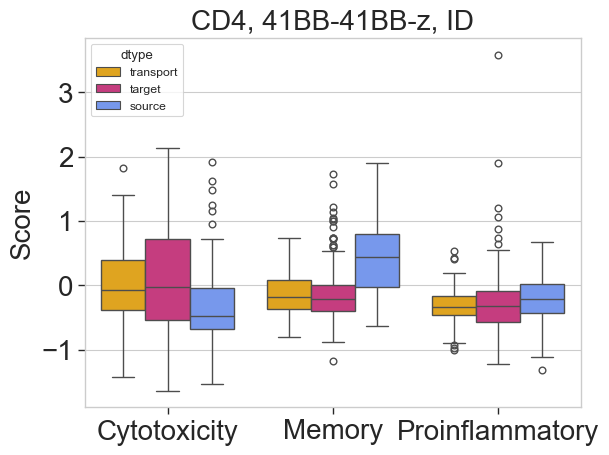

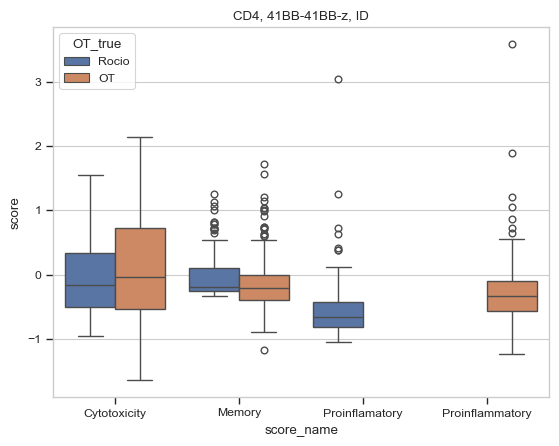

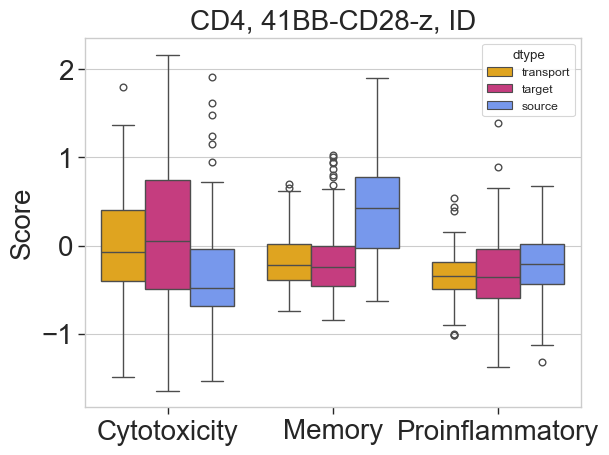

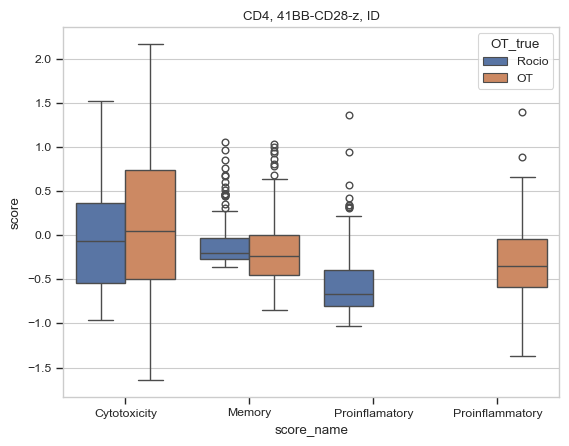

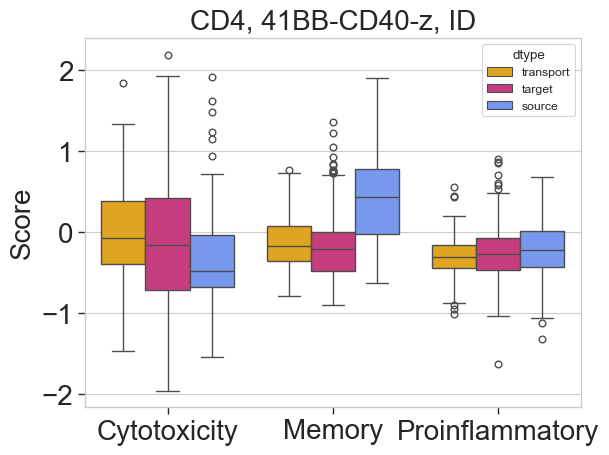

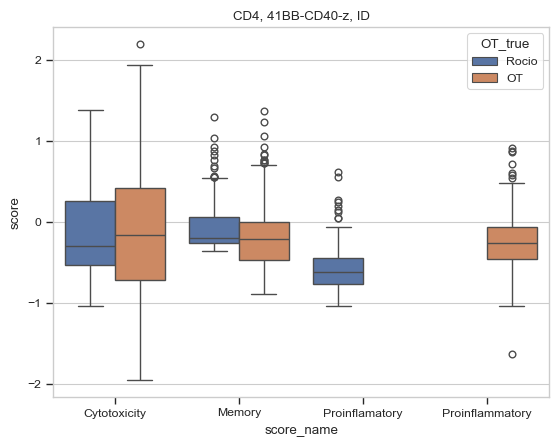

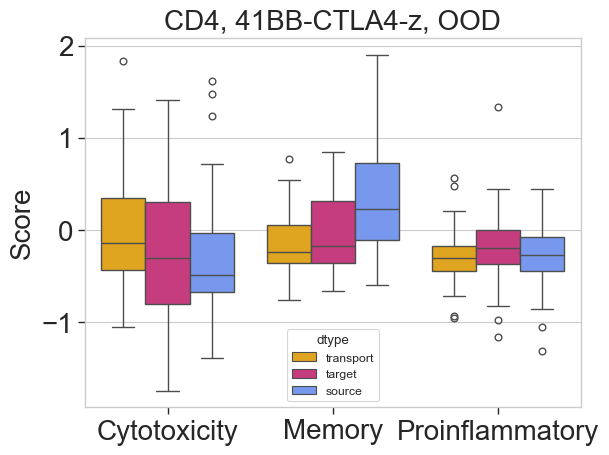

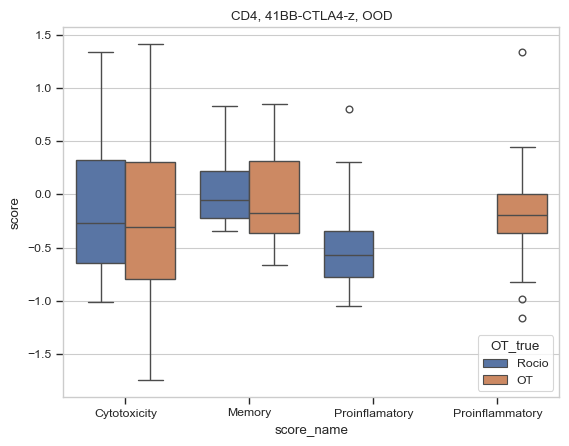

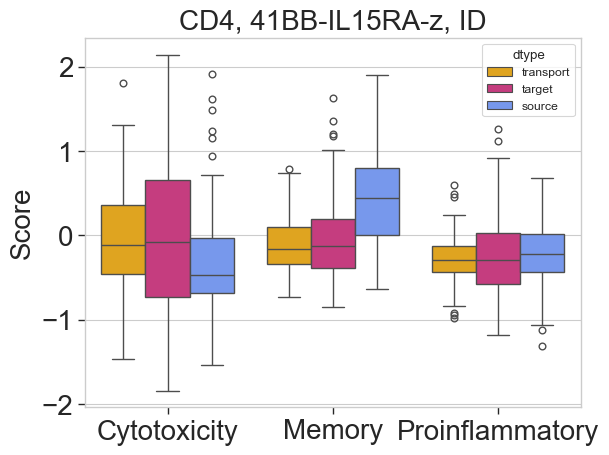

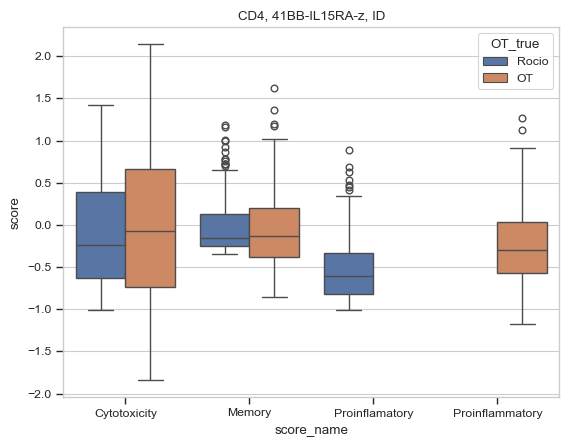

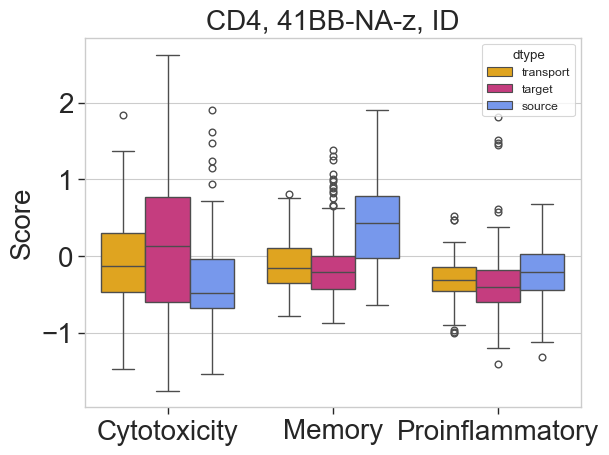

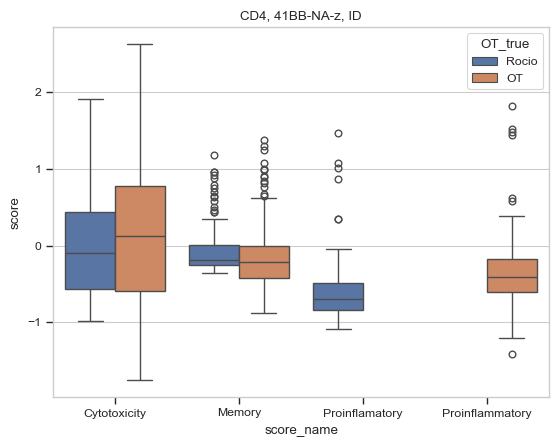

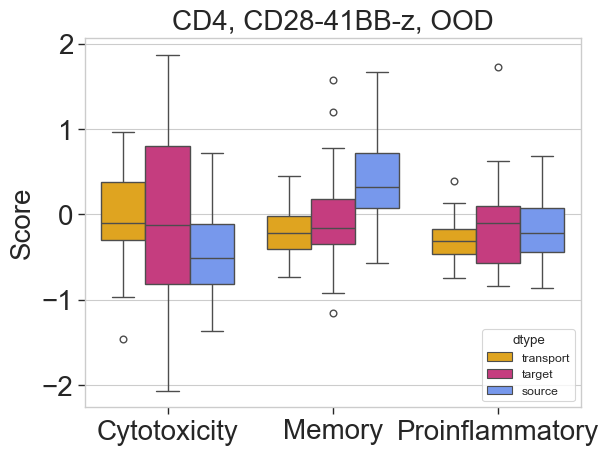

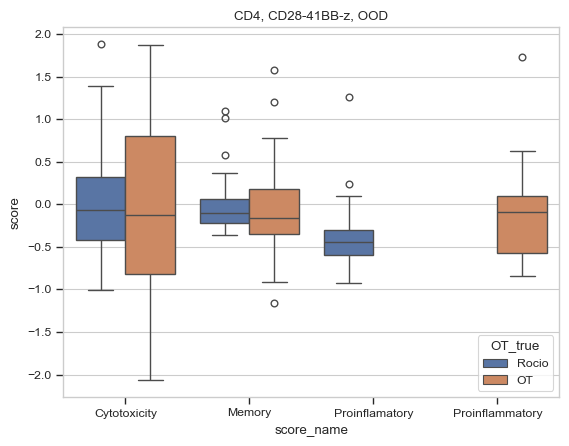

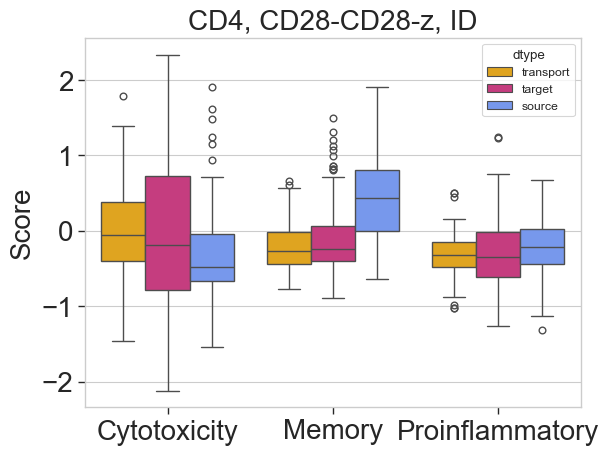

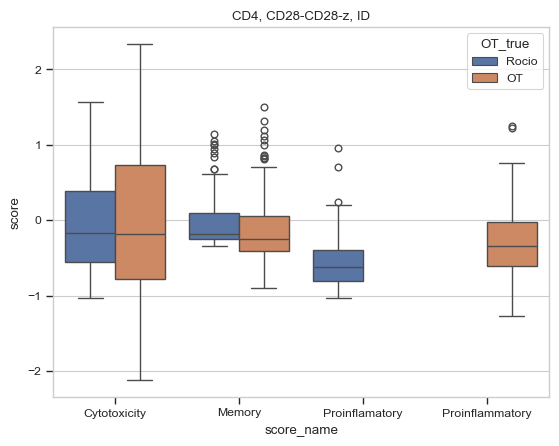

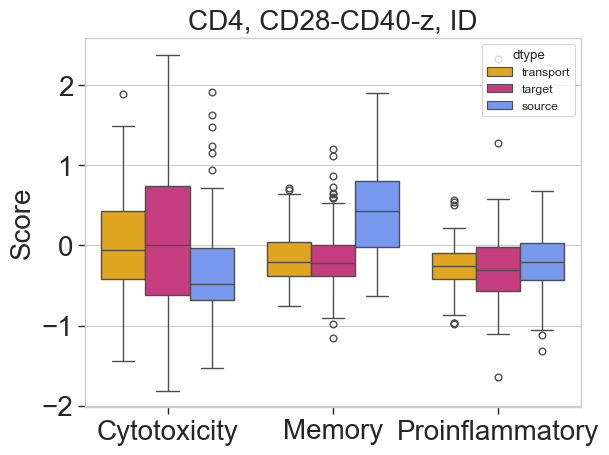

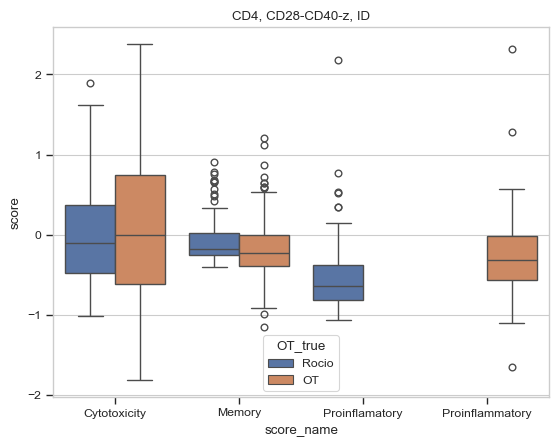

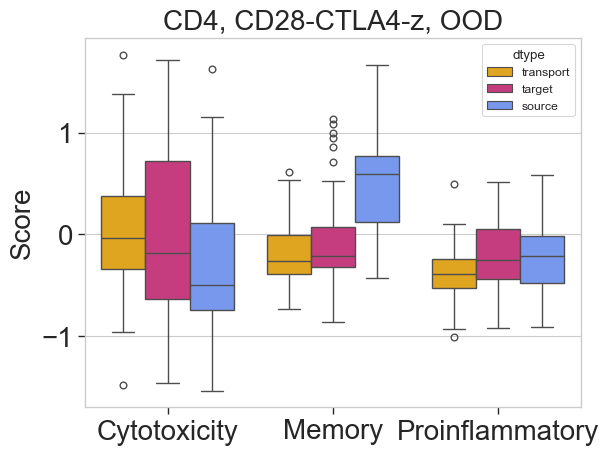

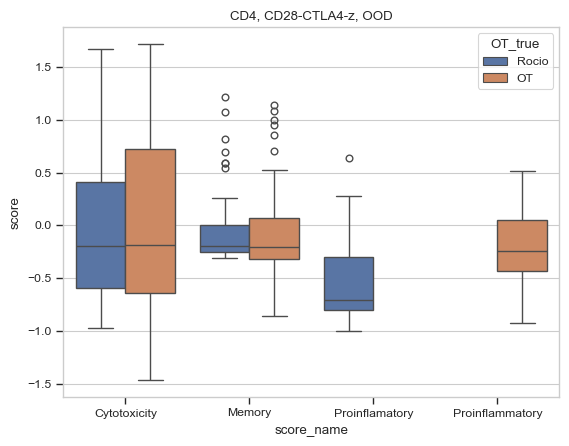

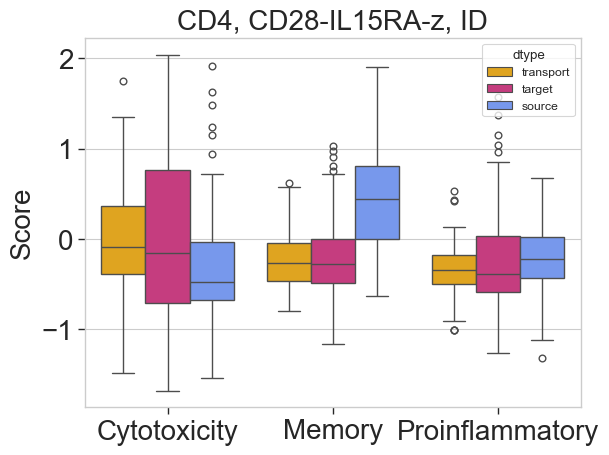

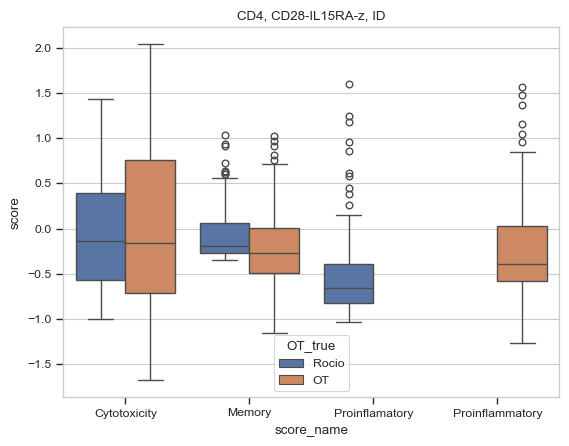

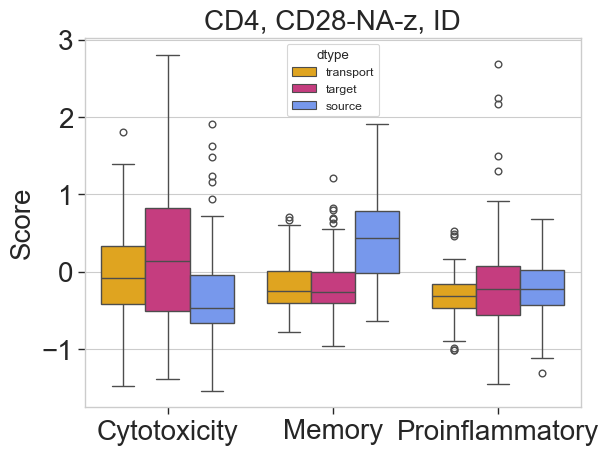

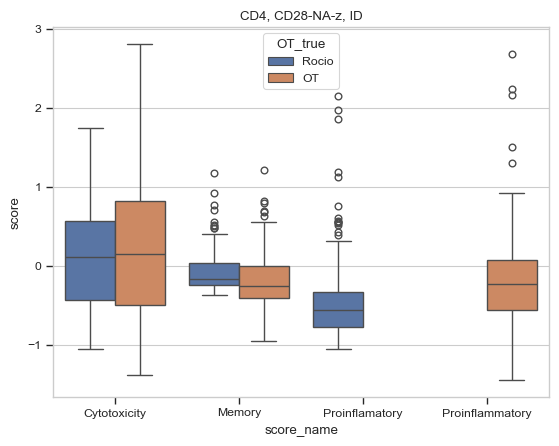

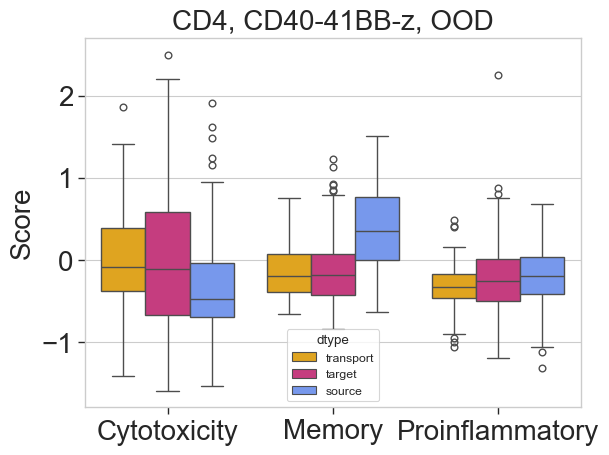

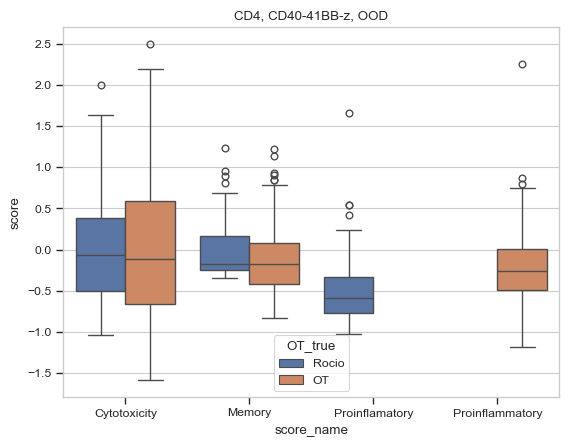

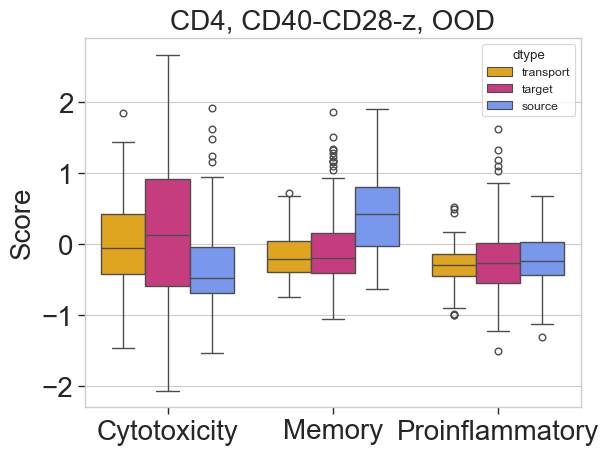

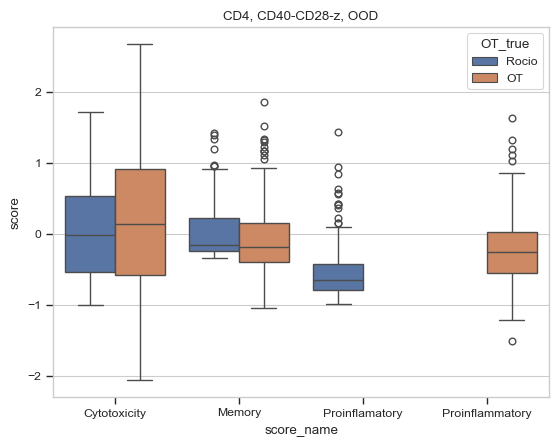

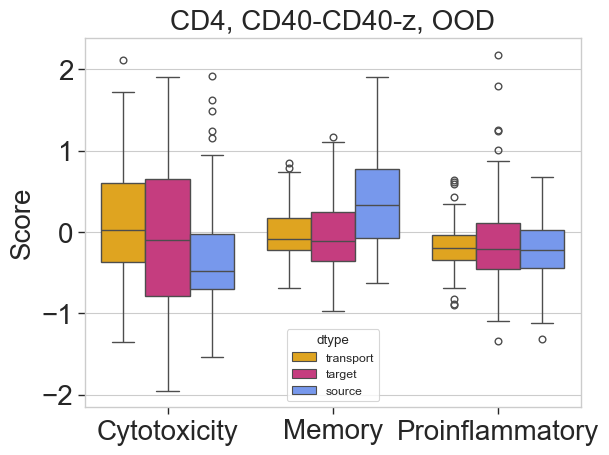

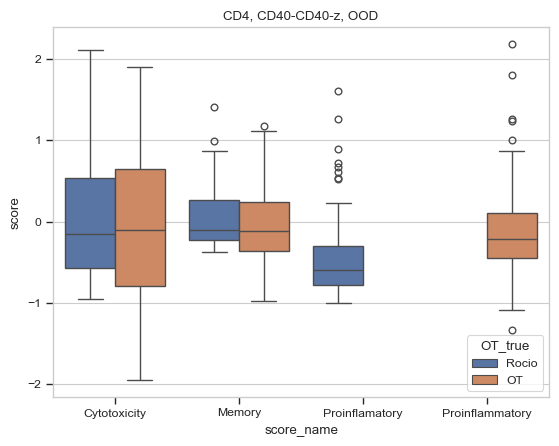

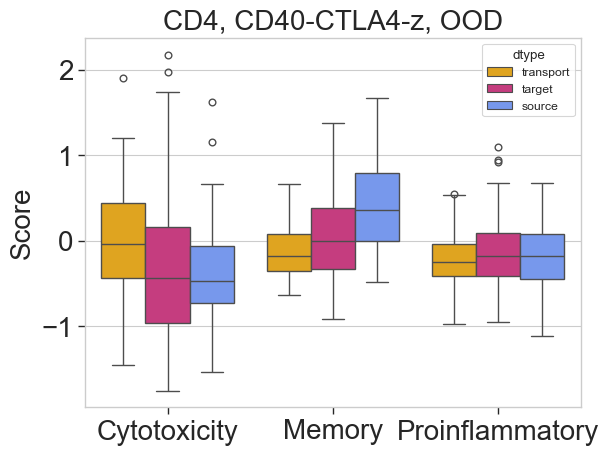

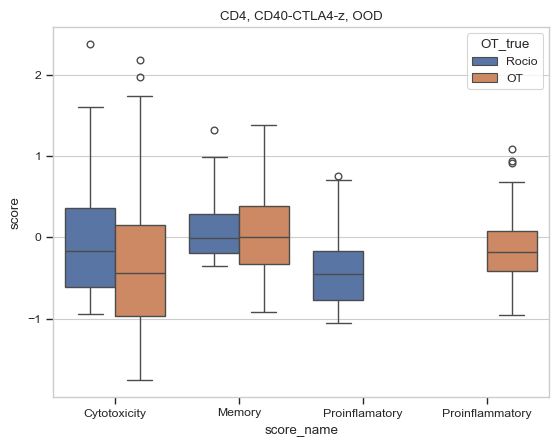

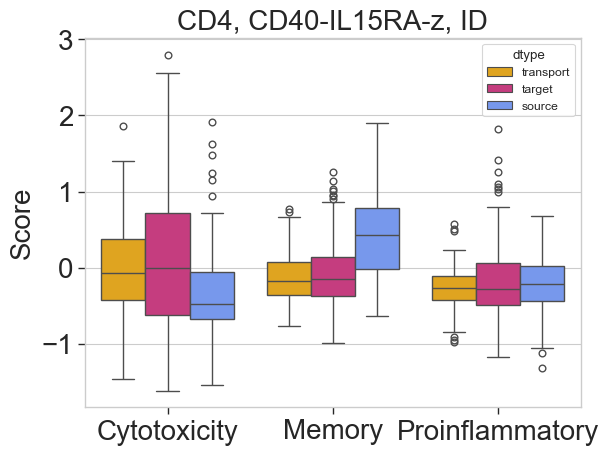

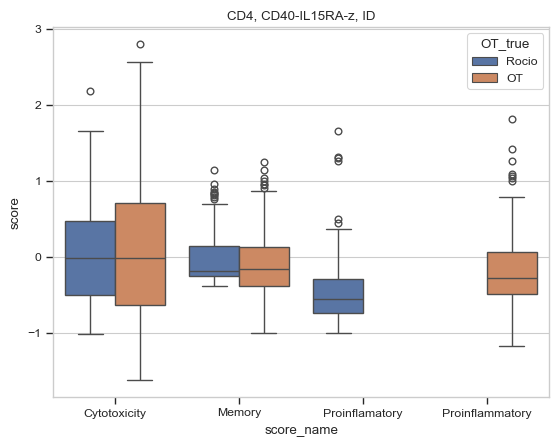

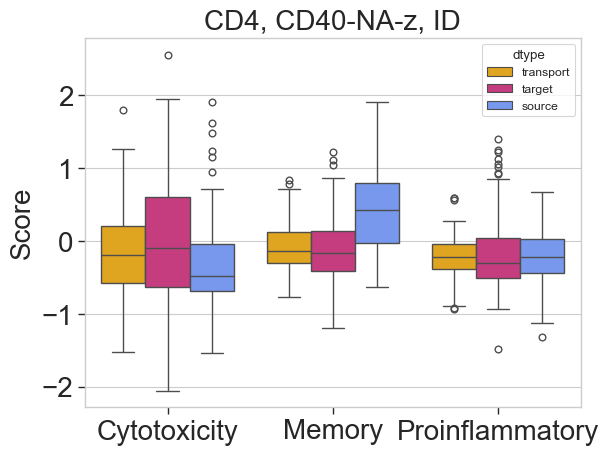

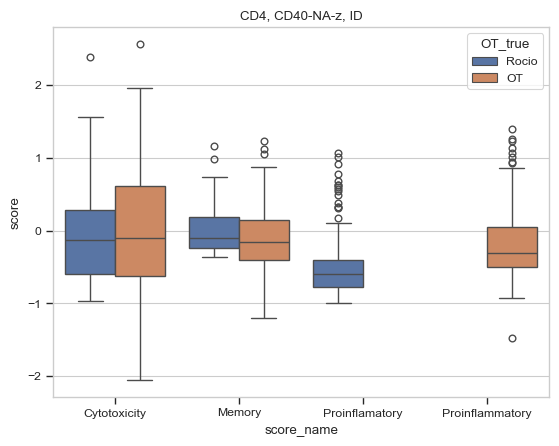

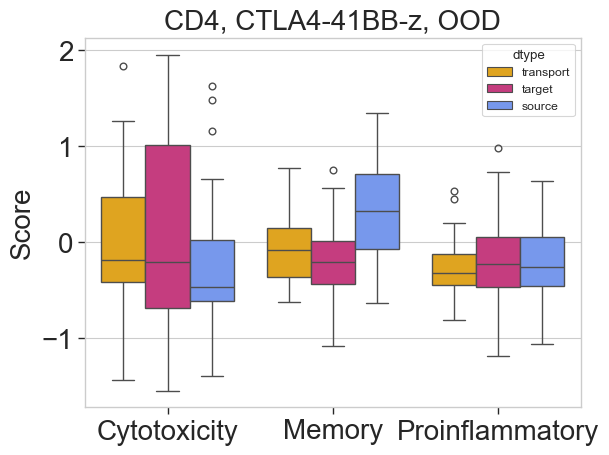

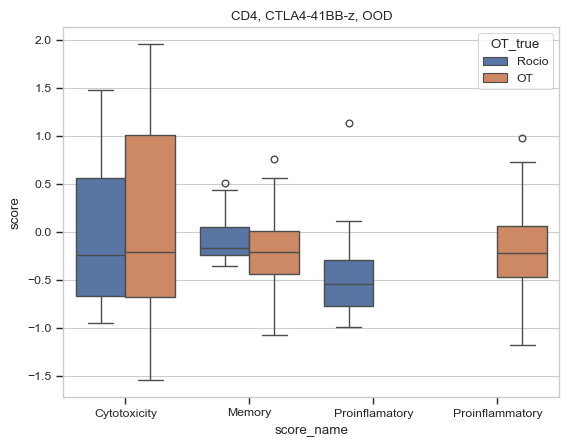

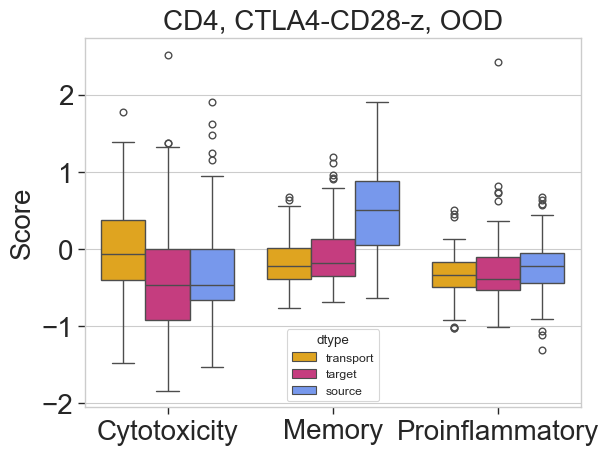

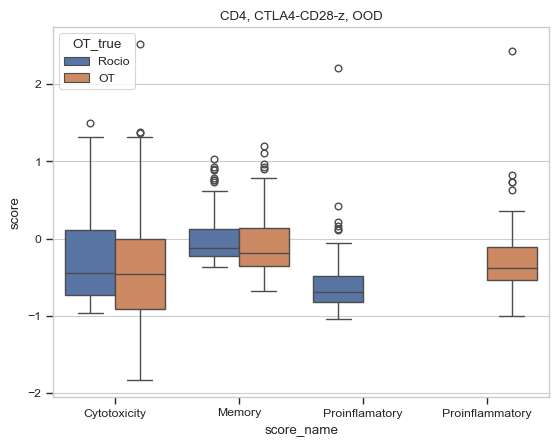

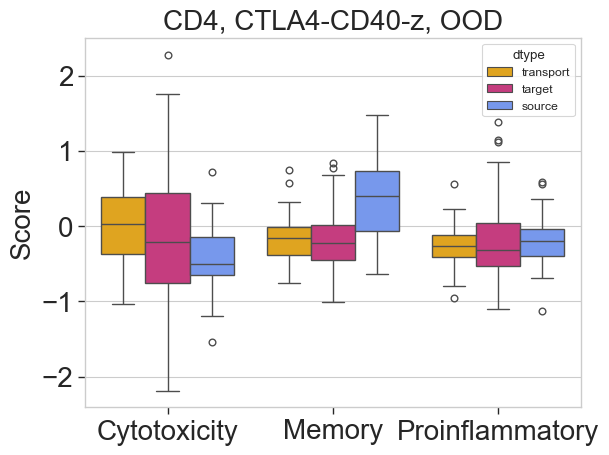

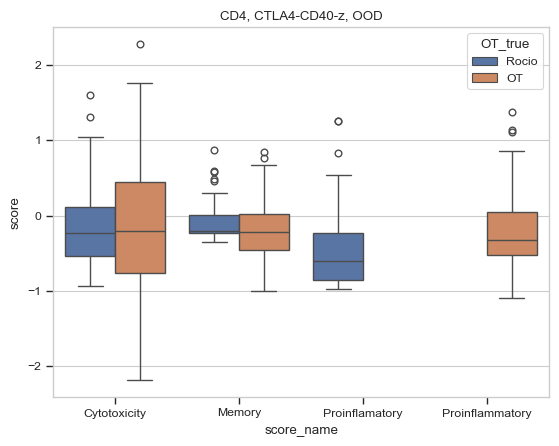

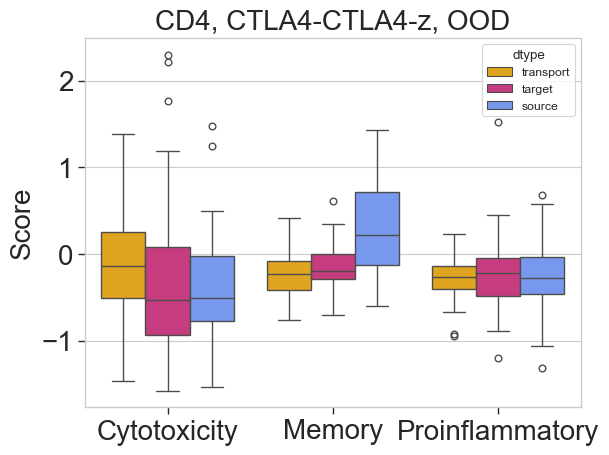

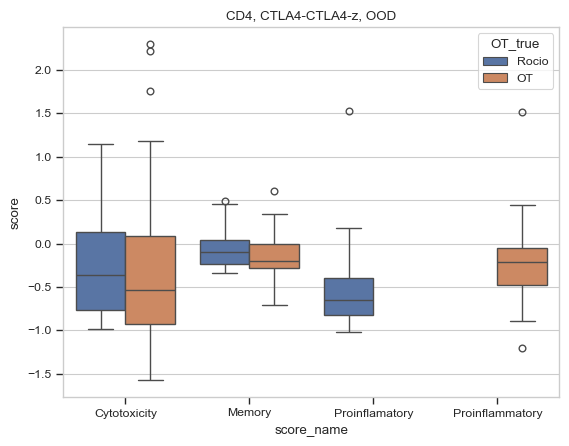

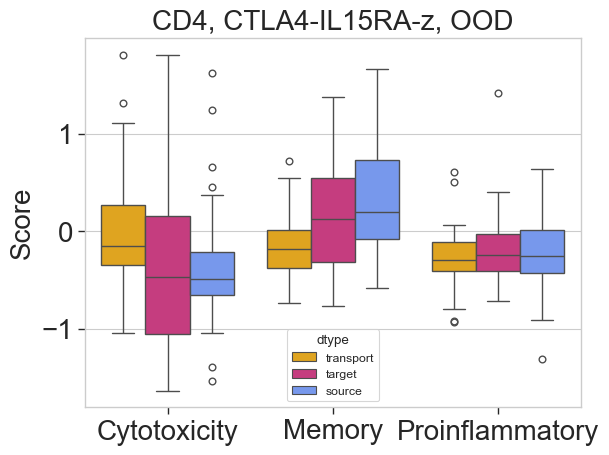

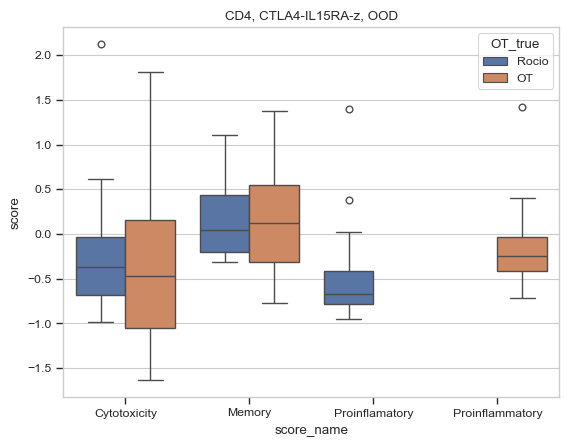

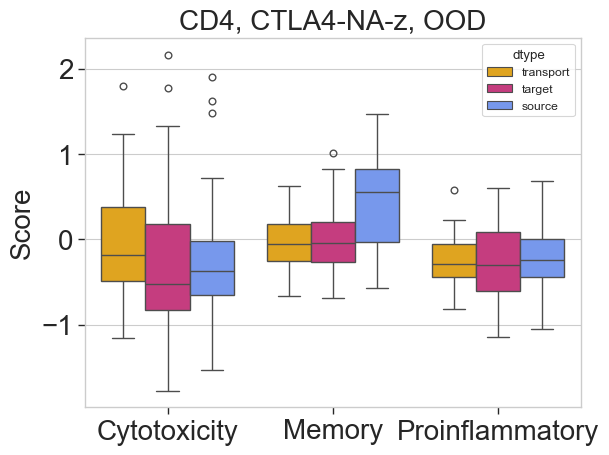

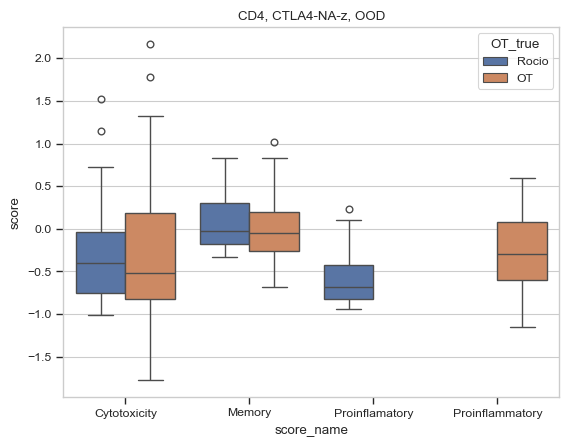

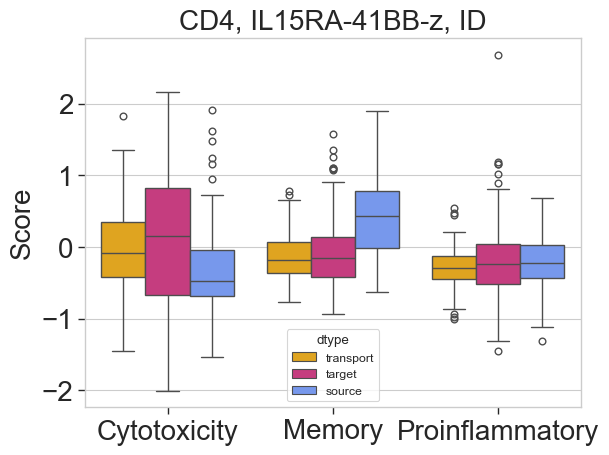

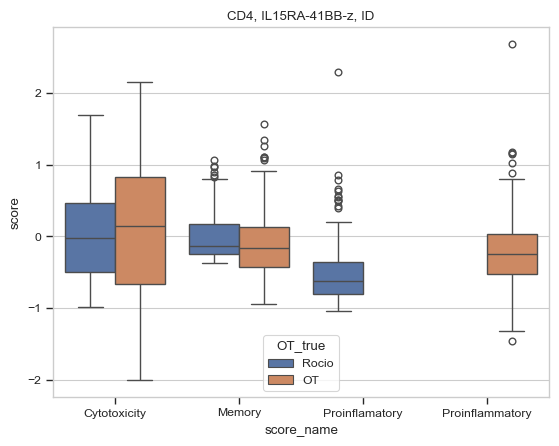

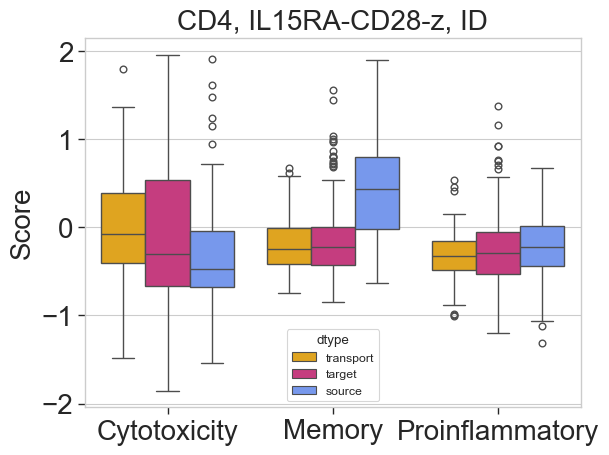

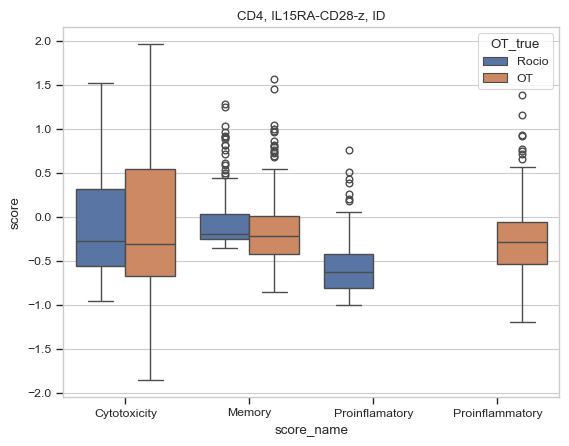

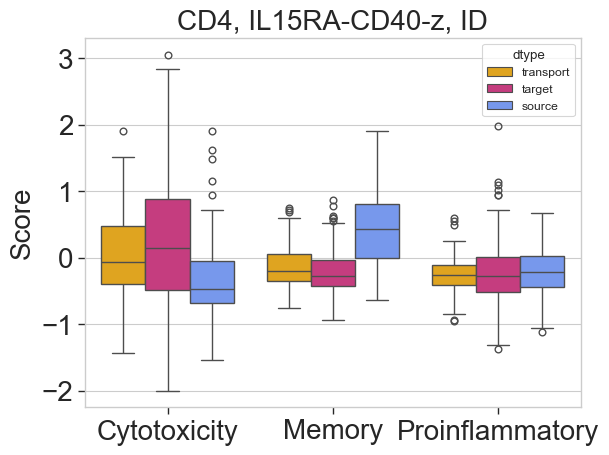

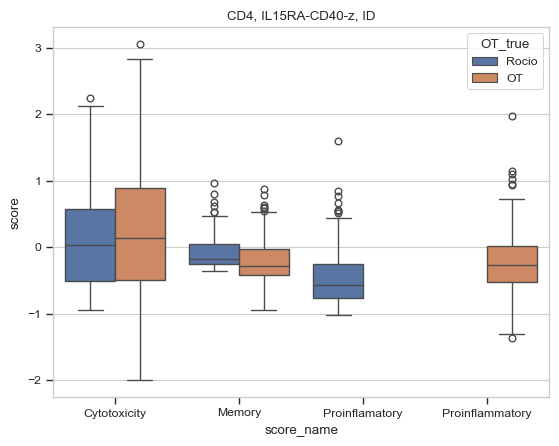

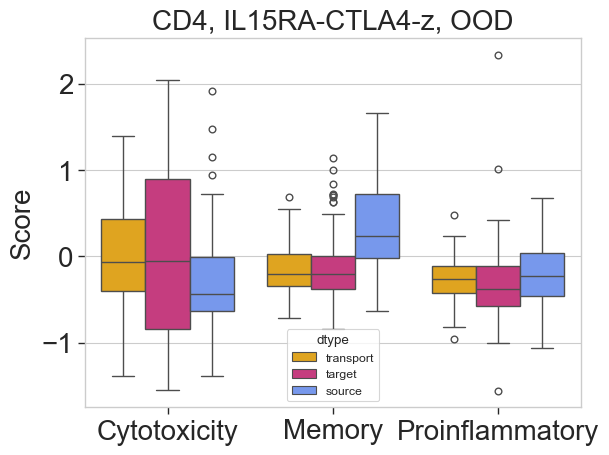

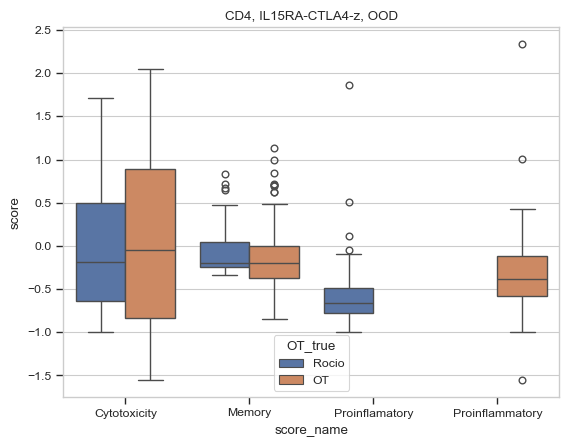

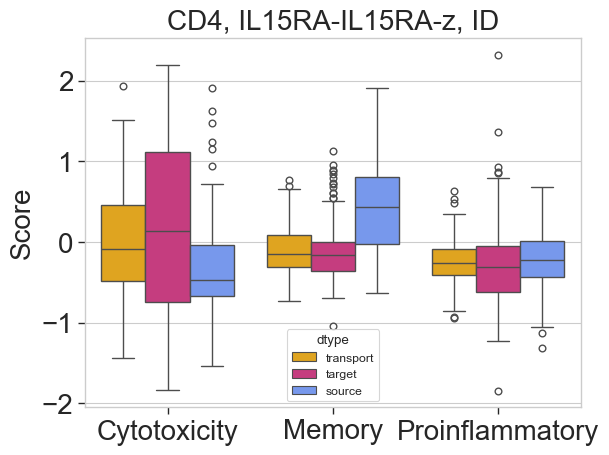

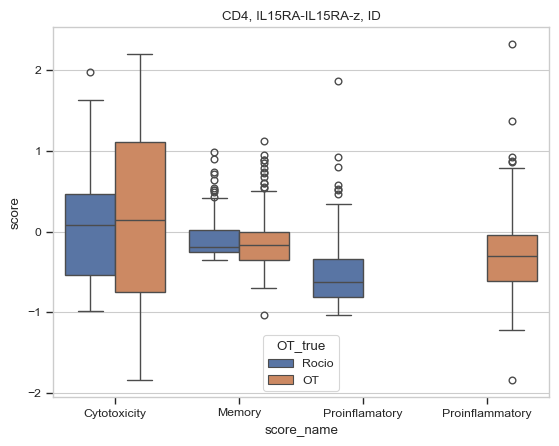

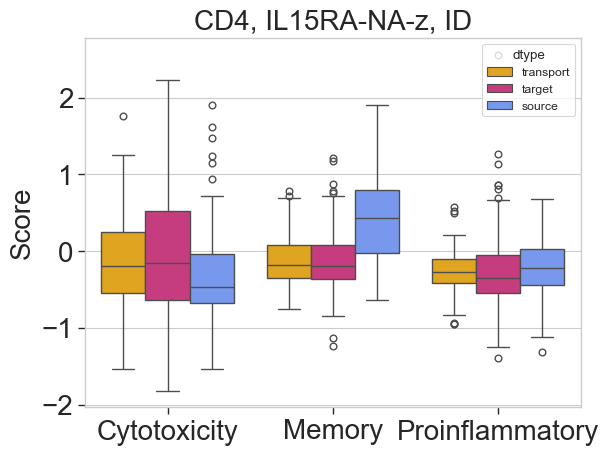

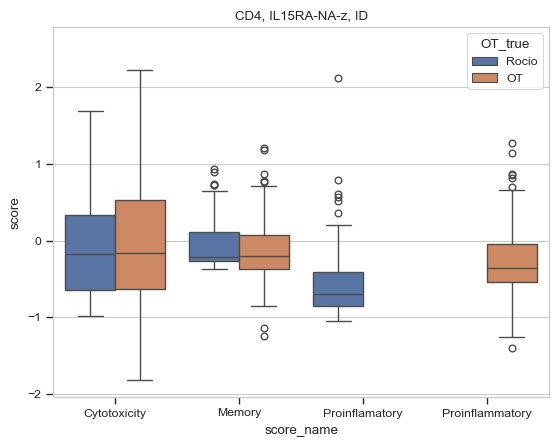

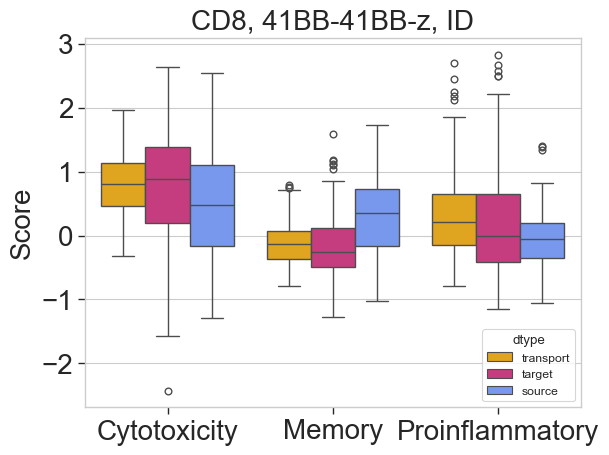

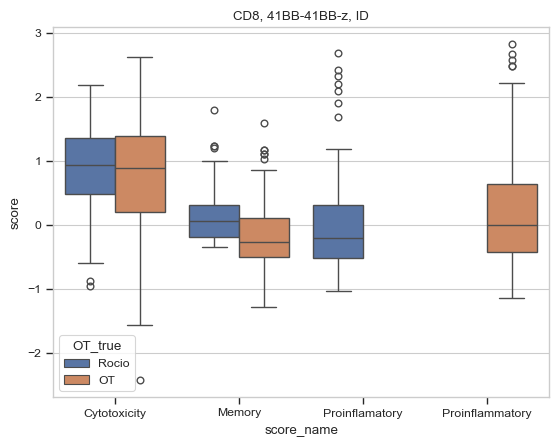

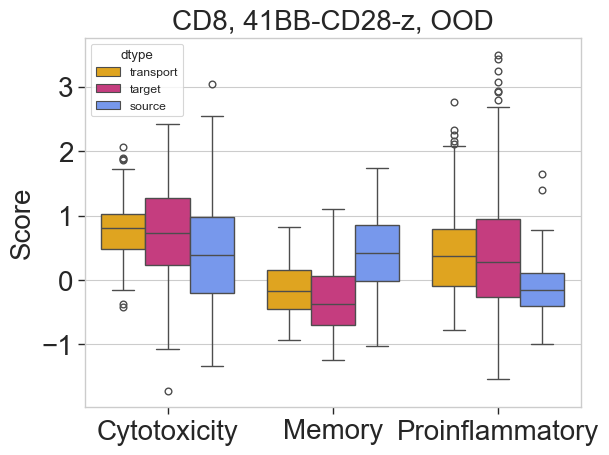

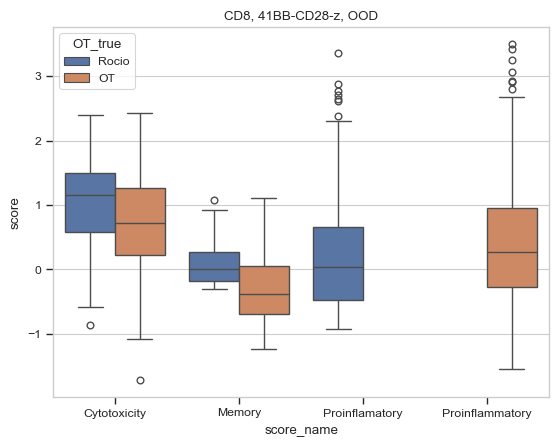

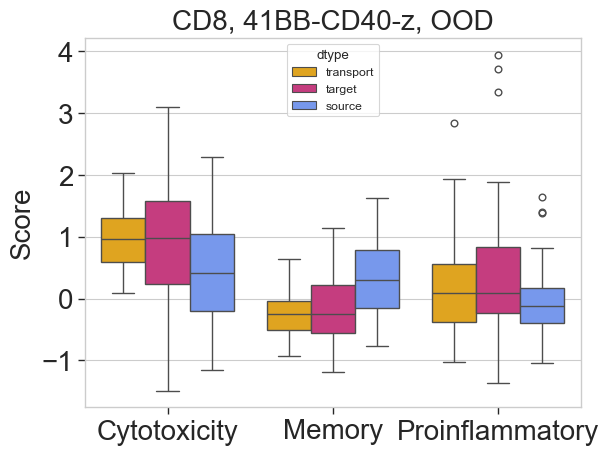

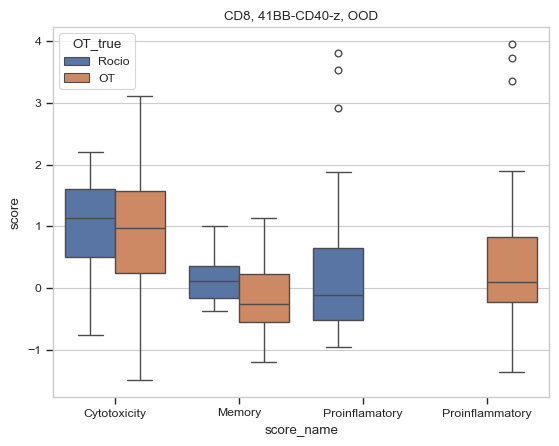

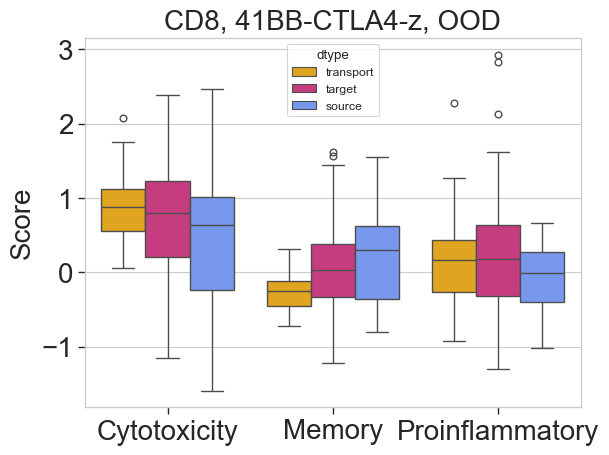

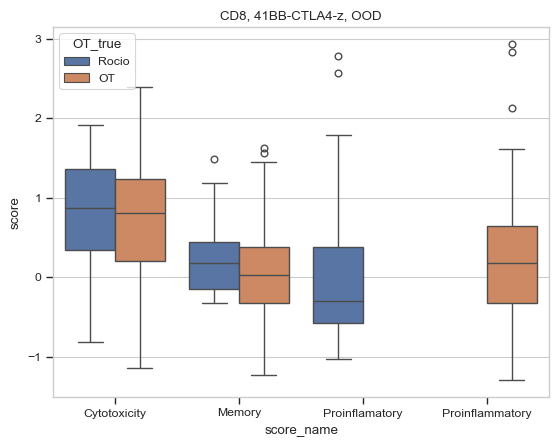

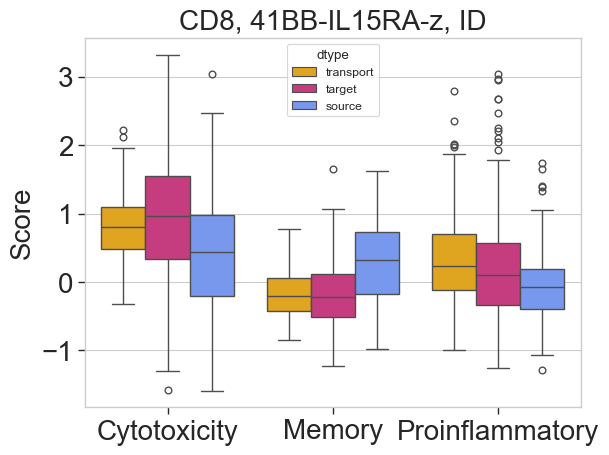

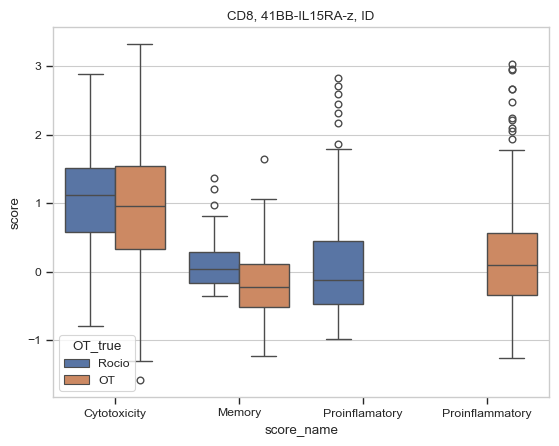

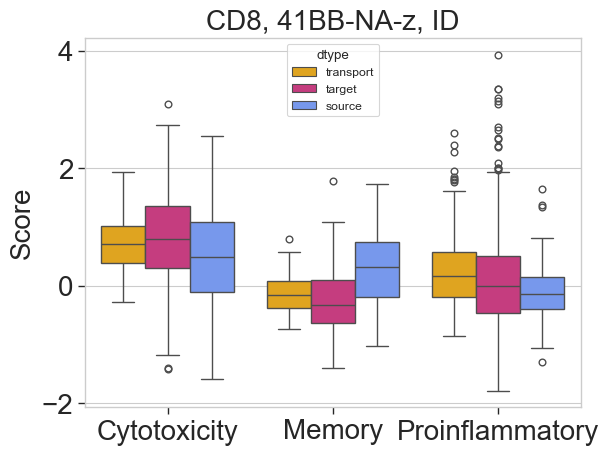

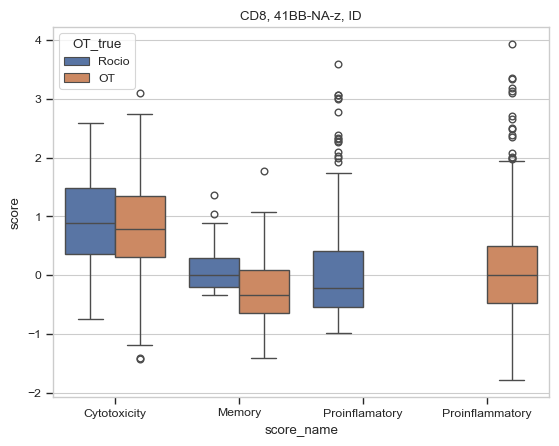

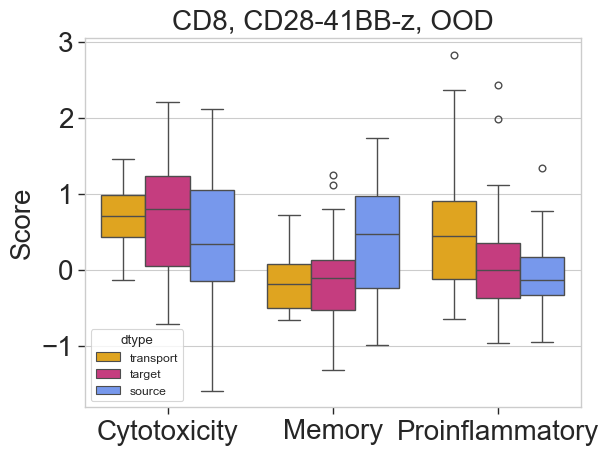

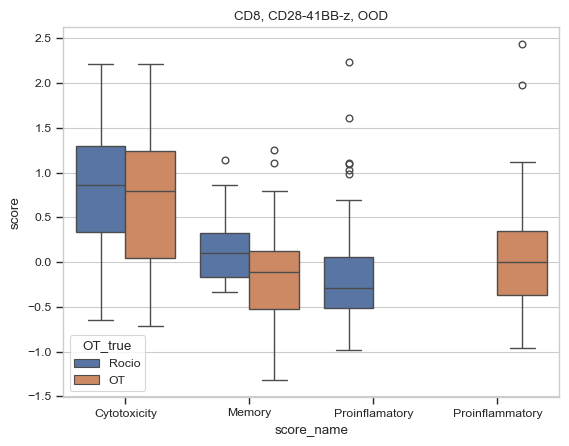

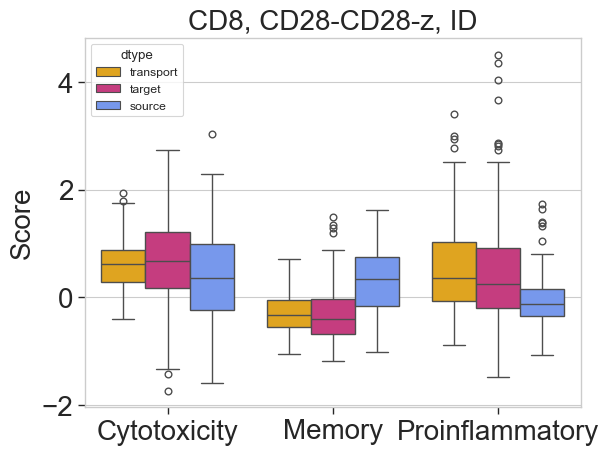

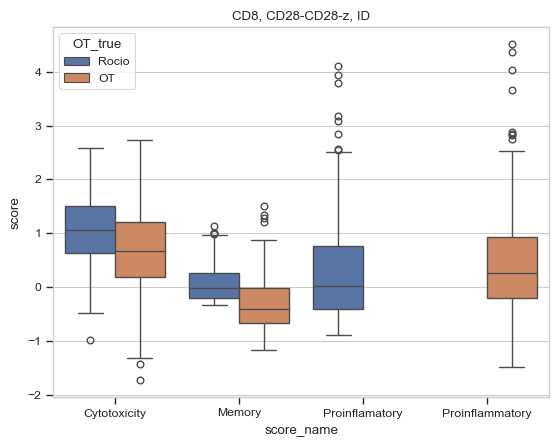

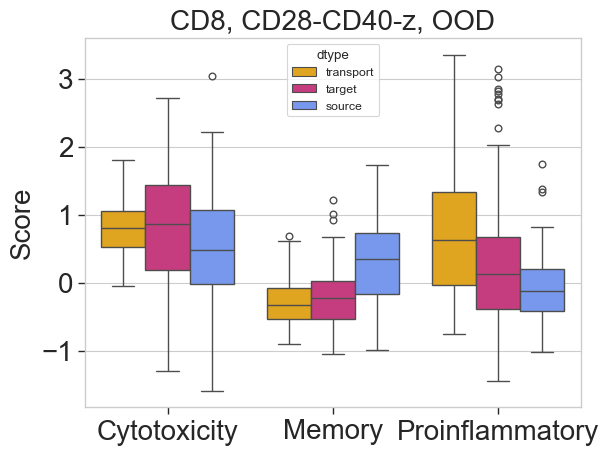

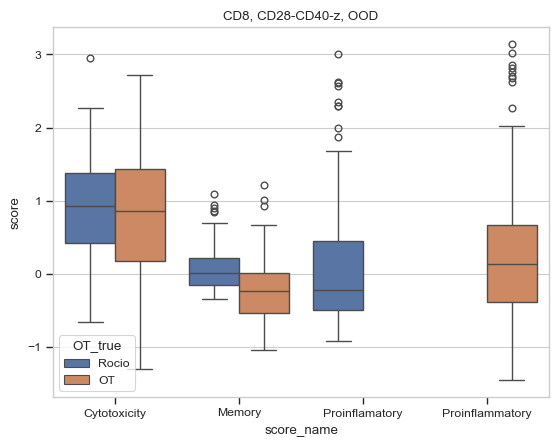

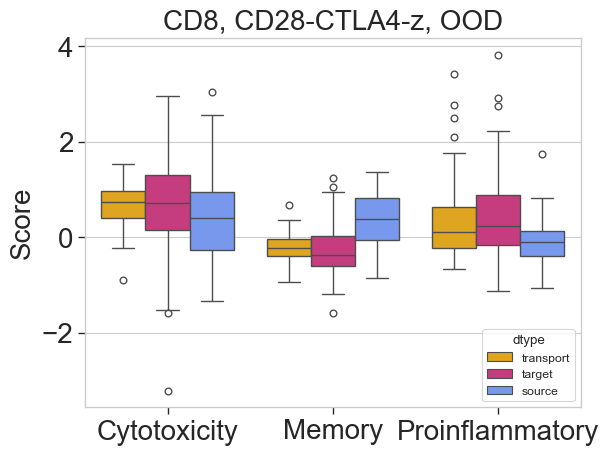

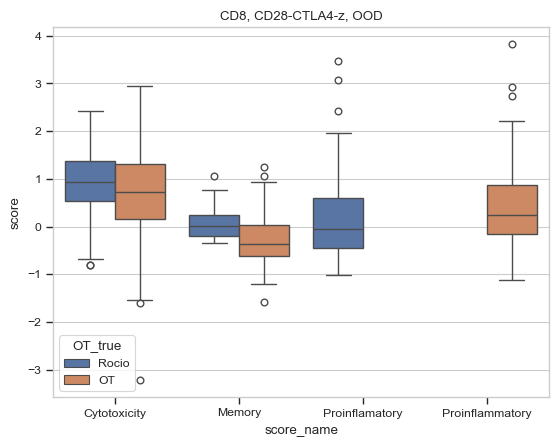

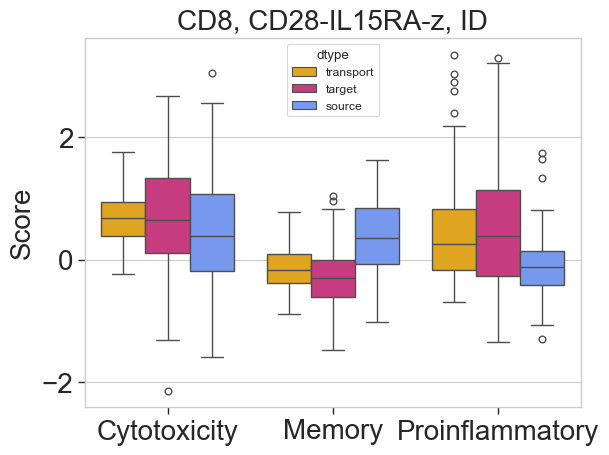

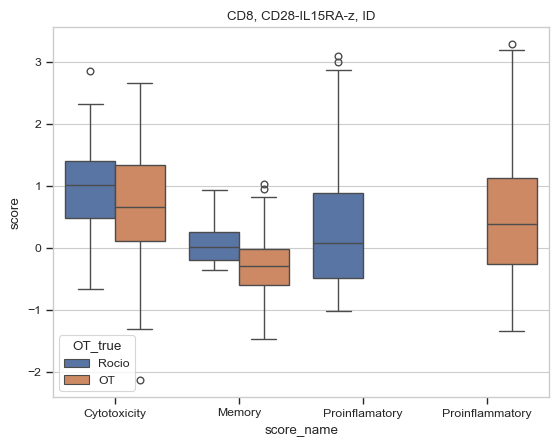

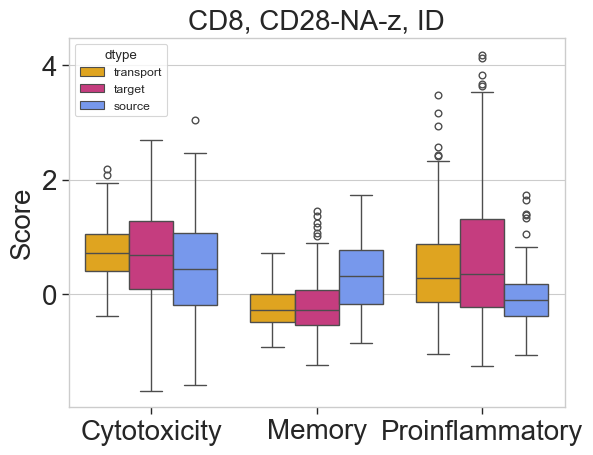

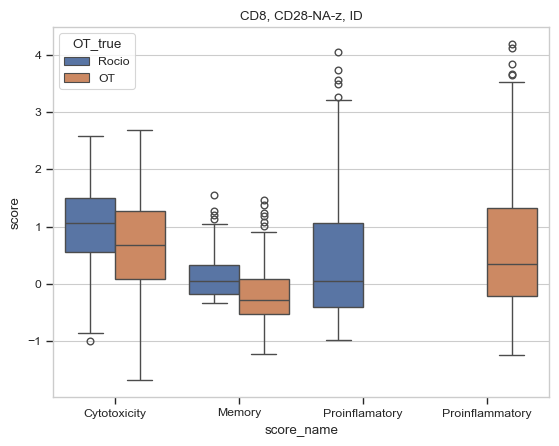

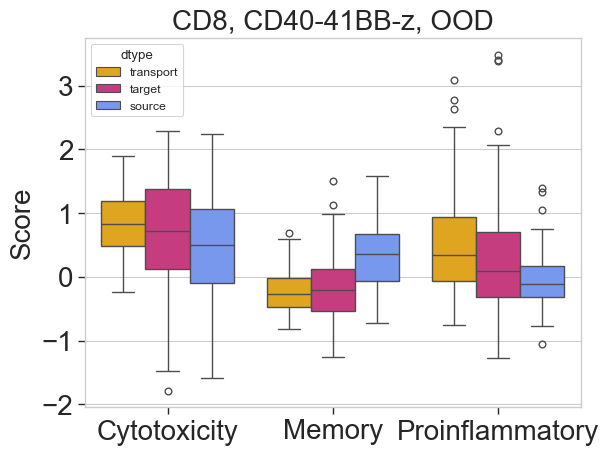

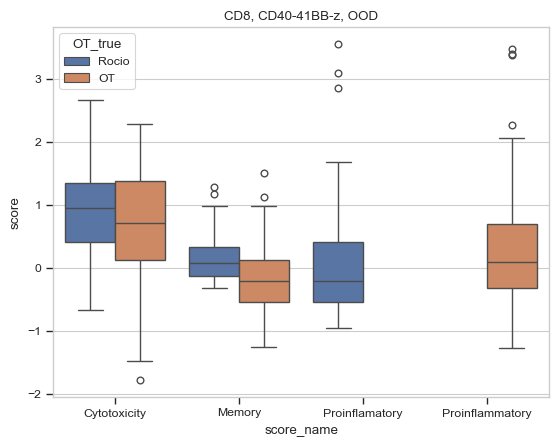

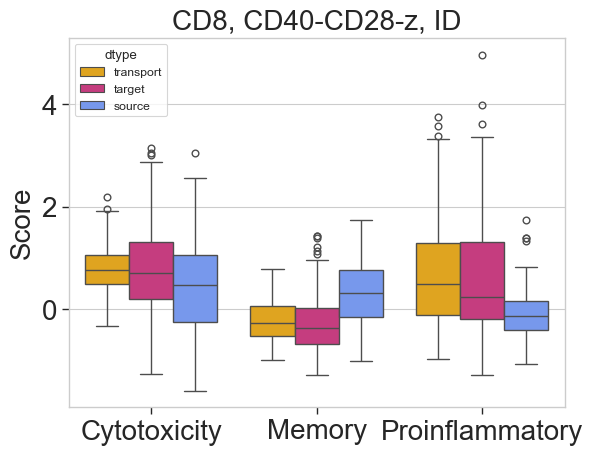

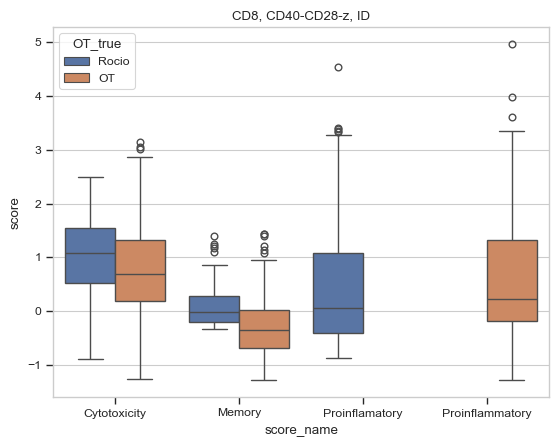

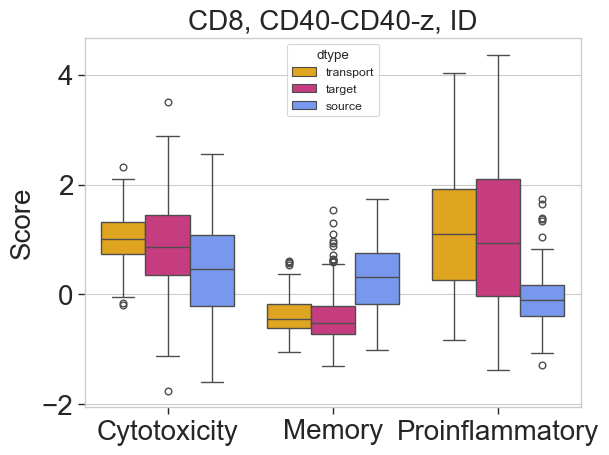

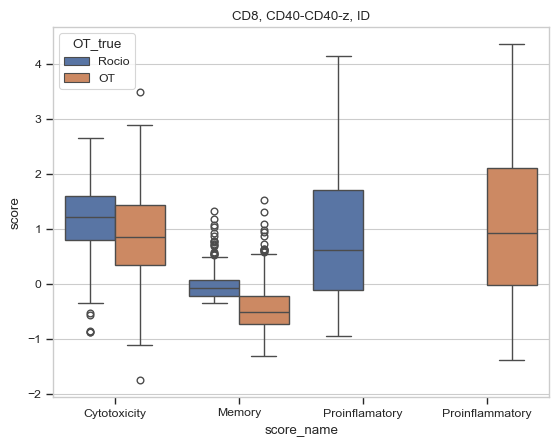

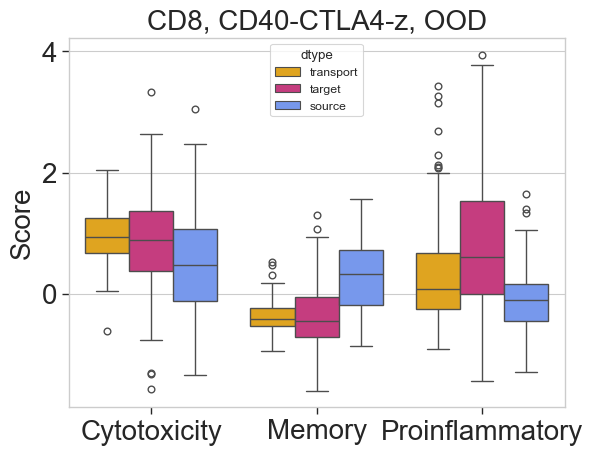

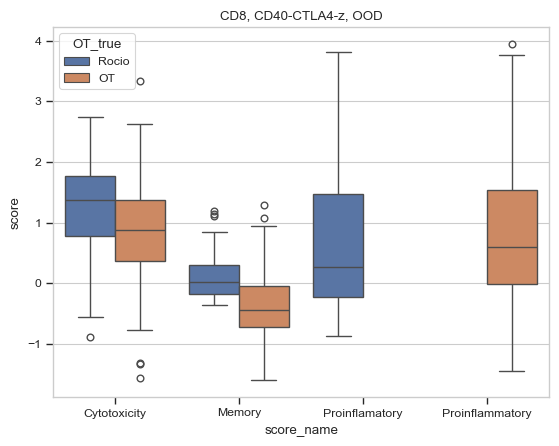

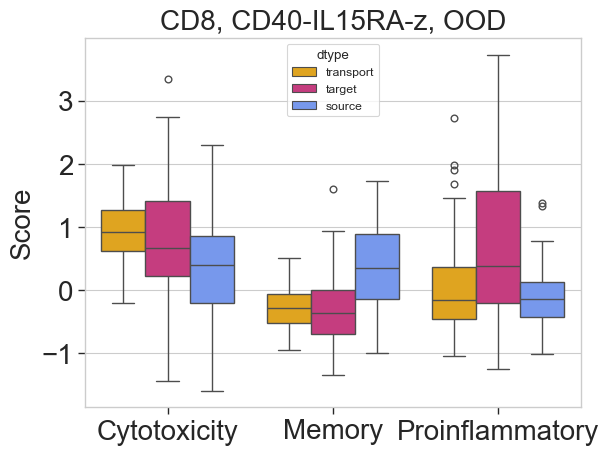

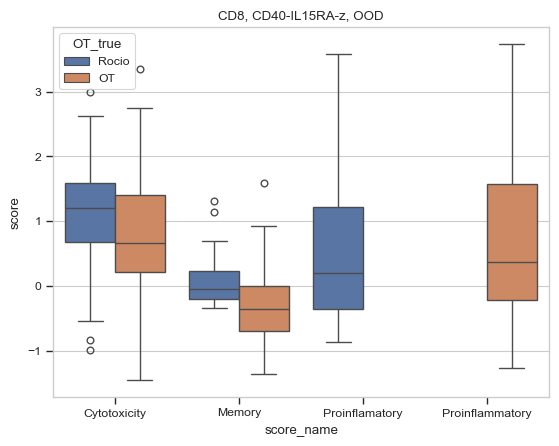

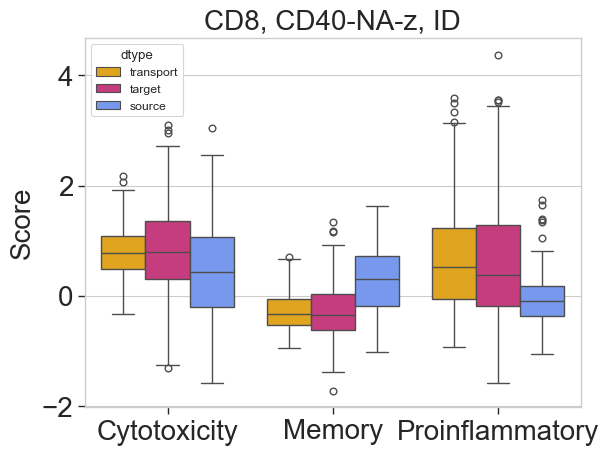

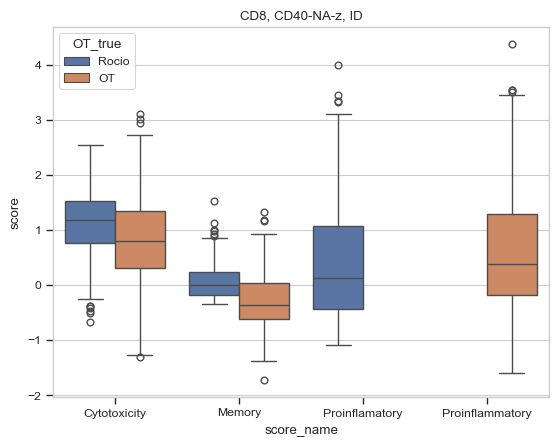

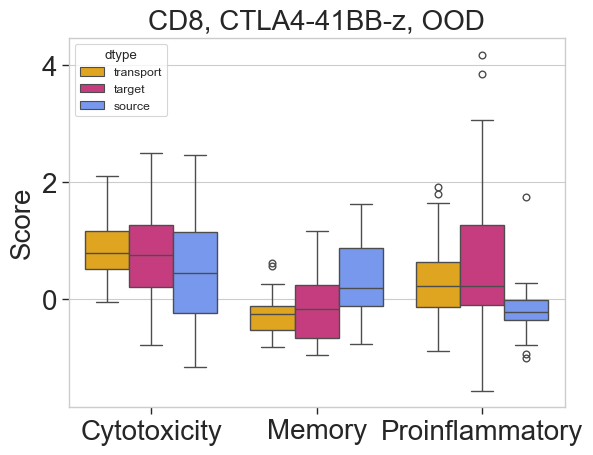

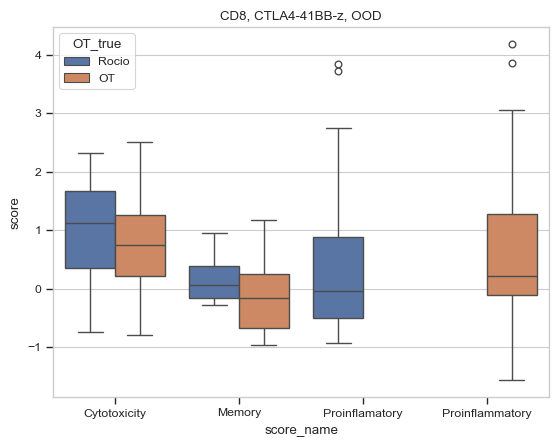

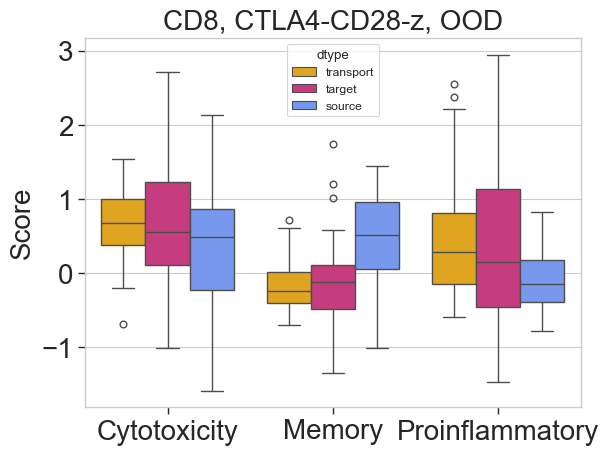

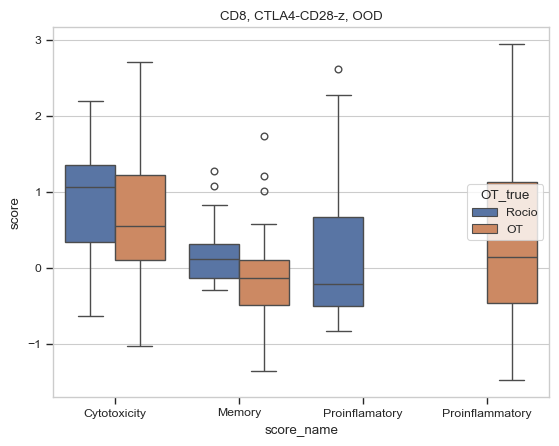

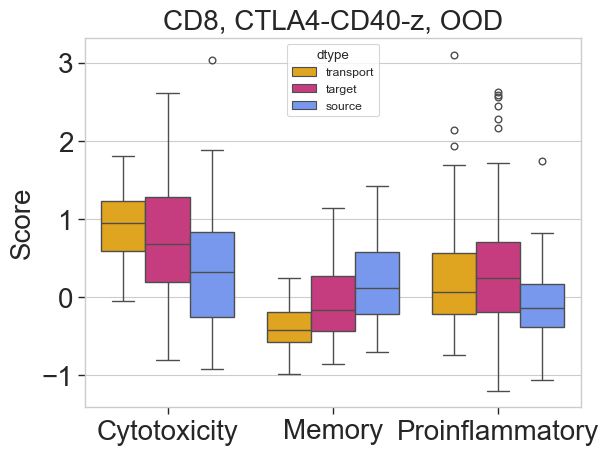

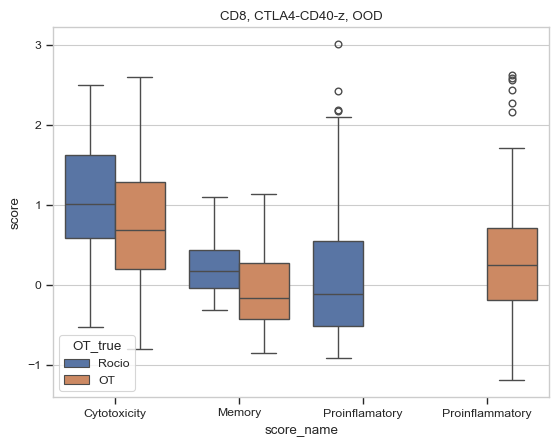

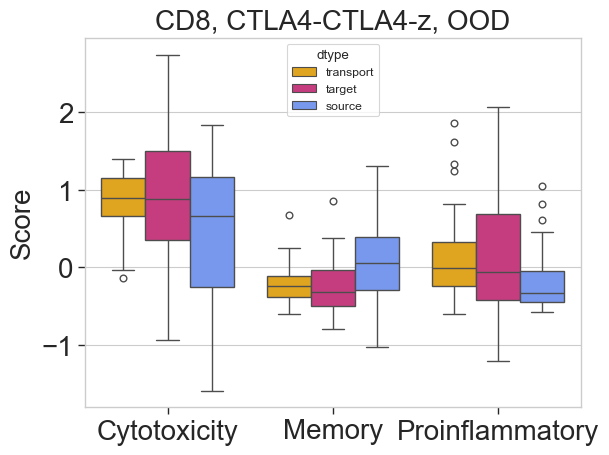

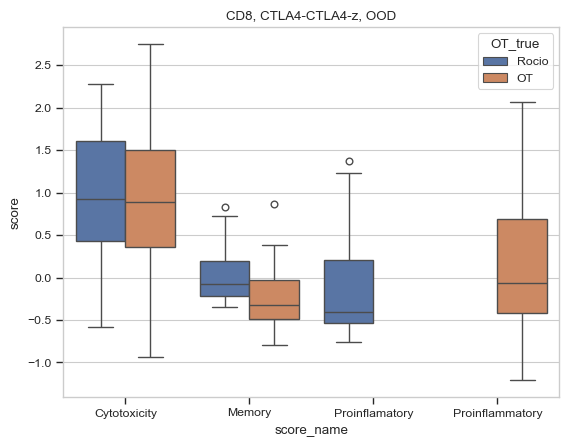

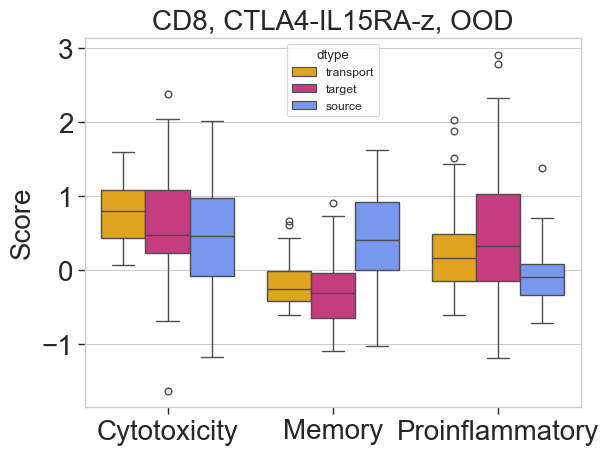

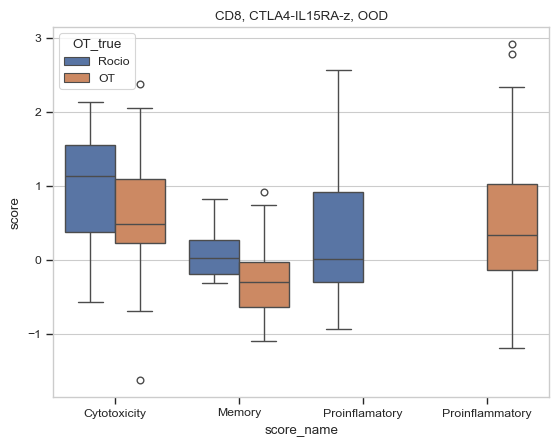

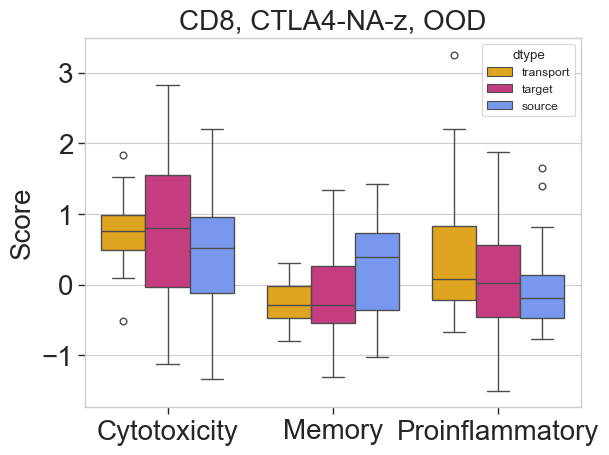

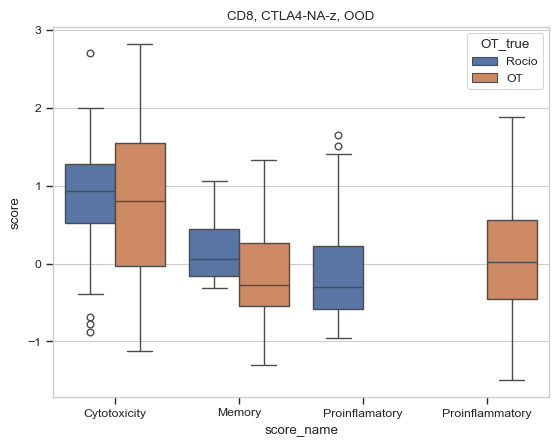

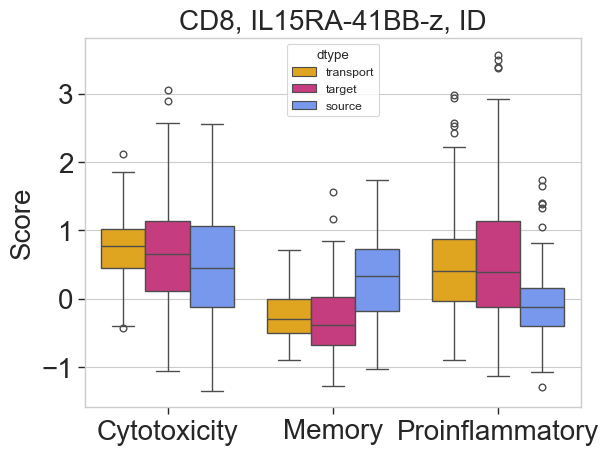

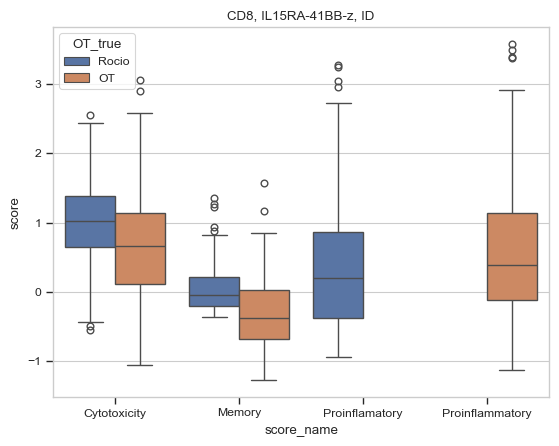

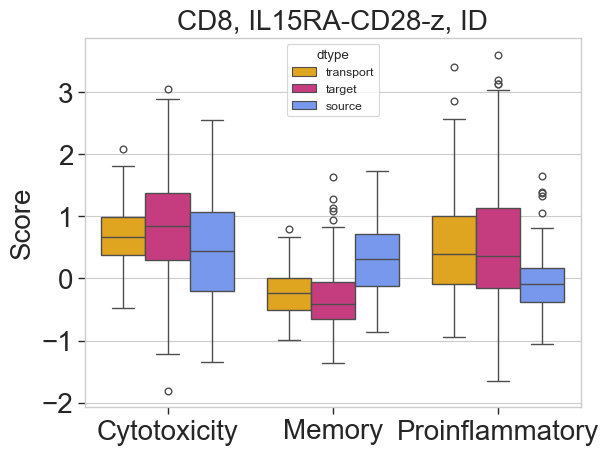

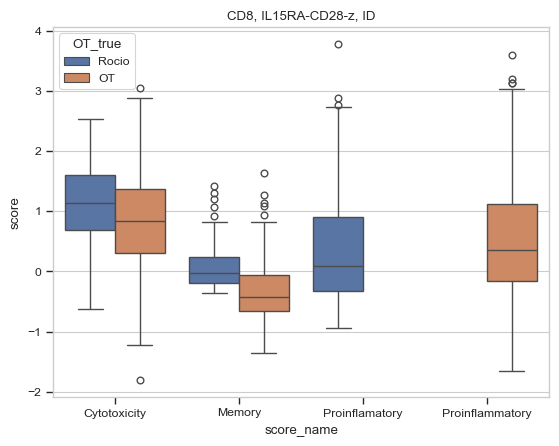

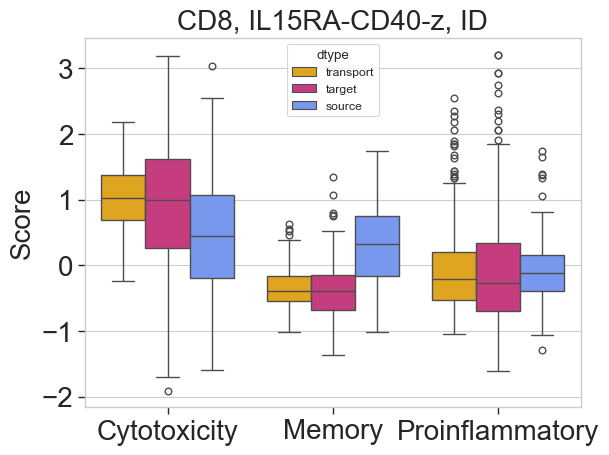

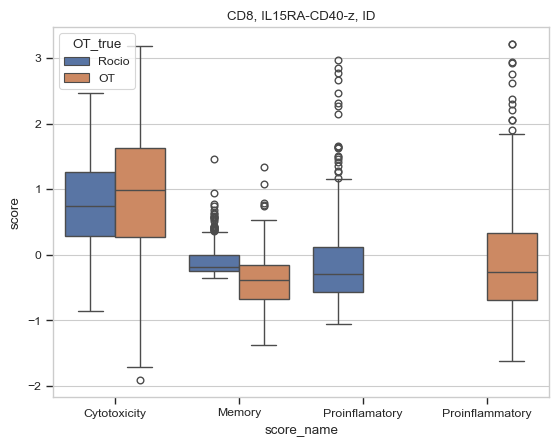

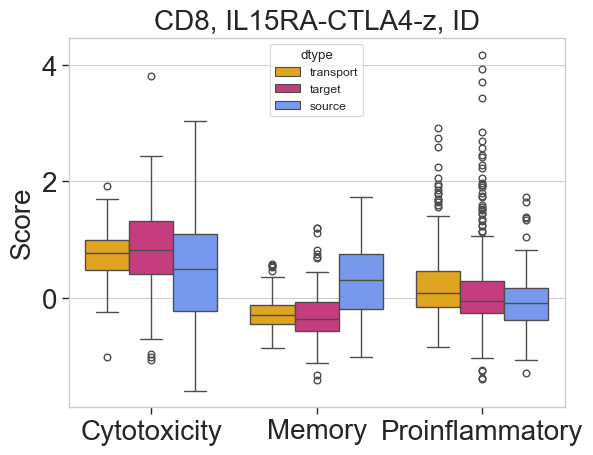

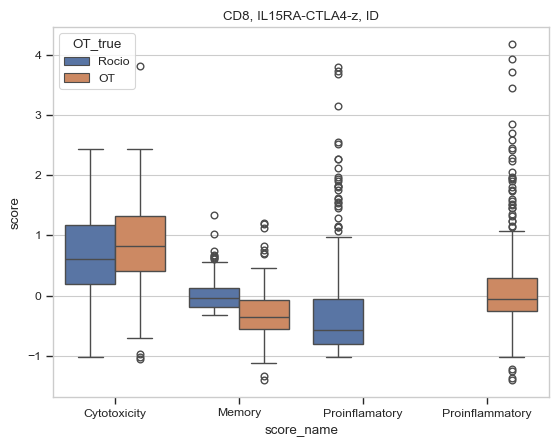

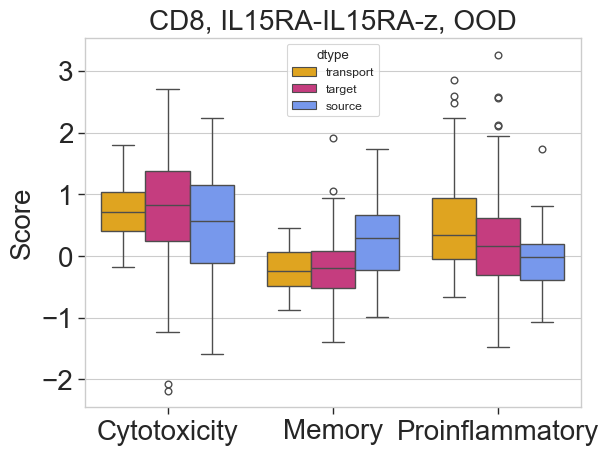

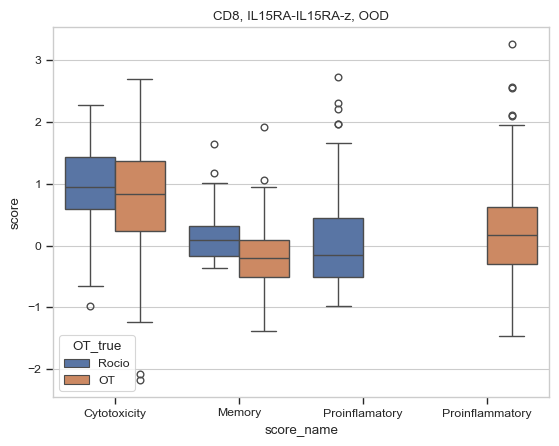

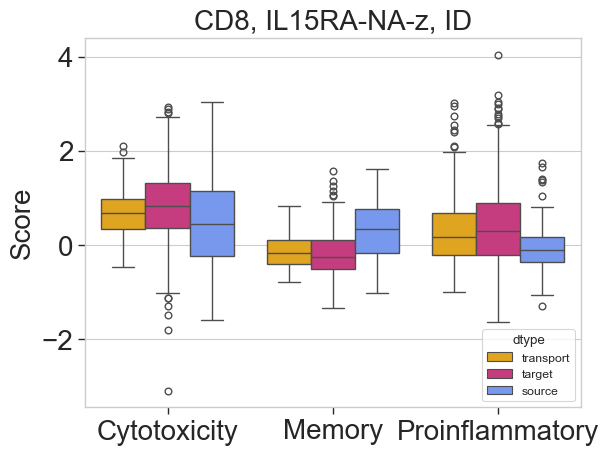

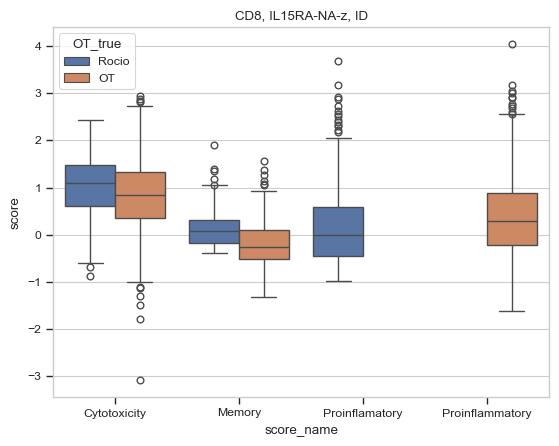

In [12]:
for subset in ["CD4", "CD8"]:
    res = adata[adata.obs["subset"]==subset]
    for car in res.obs["condition"].unique():
        data1 = res[(res.obs["dtype"]=="transport")&(res.obs["condition"]==car)].obs.loc[:, ["Cytotoxicity_1", "Memory_3", "Proinflamatory_2",
                                                                                    "Cytotoxicity_OT", "Memory_OT", "Proinflammatory_OT"]]
        data1 = data1.reset_index().melt(id_vars="index", value_name="score", var_name="OT_true")
        data1[["score_name", "OT_true"]] = [s.split("_") for s in data1["OT_true"]]
        data1.loc[data1["OT_true"]!="OT", "OT_true"] = "Rocio"
        data1['dtype'] = "transport"
    
        data2 = res[(res.obs["dtype"]=="target")&(res.obs["condition"]==car)].obs.loc[:, ["Cytotoxicity_1", "Memory_3", "Proinflamatory_2",
                                                                                    "Cytotoxicity_OT", "Memory_OT", "Proinflammatory_OT"]]
        data2 = data2.reset_index().melt(id_vars="index", value_name="score", var_name="OT_true")
        data2[["score_name", "OT_true"]] = [s.split("_") for s in data2["OT_true"]]
        data2.loc[data2["OT_true"]!="OT", "OT_true"] = "Rocio"
        data2['dtype'] = "target"
    
        data3 = res[(res.obs["dtype"]=="source")&(res.obs["condition"]==car)].obs.loc[:, ["Cytotoxicity_1", "Memory_3", "Proinflamatory_2",
                                                                                    "Cytotoxicity_OT", "Memory_OT", "Proinflammatory_OT"]]
        data3 = data3.reset_index().melt(id_vars="index", value_name="score", var_name="OT_true")
        data3[["score_name", "OT_true"]] = [s.split("_") for s in data3["OT_true"]]
        data3.loc[data3["OT_true"]!="OT", "OT_true"] = "Rocio"
        data3['dtype'] = "source"
    
        data1.loc[data1["OT_true"]=="true", "score"] = data2.loc[data2["OT_true"]=="true", "score"].values
        data=pd.concat([data1, data2, data3])
        data["CAR_Variant"] = car
        data["subset"] = subset
        
        sns.boxplot(data=data[data["OT_true"]=="OT"], x="score_name", y="score", hue="dtype", palette=ot_map, hue_order=["transport", "target", "source"])
        plt.title(f"{subset}, {car}, {'ID' if car in sel_cars[subset] else 'OOD'}", fontsize=20)
        plt.xlabel("")
        plt.ylabel("Score", fontsize=20)
        plt.tick_params(which="both", axis="both", labelsize=20)
        plt.savefig(f"{base_fig_save}{subset}_{car}_score_comparison_box.pdf", bbox_inches="tight")
        plt.show()

        sns.boxplot(data=data[data["dtype"]=="target"], x="score_name", y="score", hue="OT_true")
        plt.title(f"{subset}, {car}, {'ID' if car in sel_cars[subset] else 'OOD'}")
        plt.show()



# Threshold determination

In [13]:
all_adata = sc.read_h5ad(f"/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Data/D09D17/20240229_from_rocio_for_manuscript.h5ad")
all_adata.X = all_adata.layers["logcounts"]
sc.tl.score_genes(all_adata, genesets["Cytotoxicity"], score_name="Cytotoxicity_OT")
sc.tl.score_genes(all_adata, genesets["Proinflammatory"], score_name="Proinflammatory_OT")
sc.tl.score_genes(all_adata, genesets["Memory"], score_name="Memory_OT")

In [14]:
all_adata

AnnData object with n_obs × n_vars = 58949 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'CAR_Variant', 'Donor', 'Time', 'Lane', 'Sample', 'percent.mt', 'A', 'B', 'C', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.75', 'seurat_clusters', 'subset_RNA', 'subset_ADT', 'subset', 'Cytotoxicity_1', 'Proinflamatory_2', 'Memory_3', 'CD4_Th1_4', 'CD4_Th2_5', 'ident', 'Cytotoxicity_OT', 'Proinflammatory_OT', 'Memory_OT'
    obsm: 'HARMONY', 'X_pca', 'X_umap'
    layers: 'logcounts'

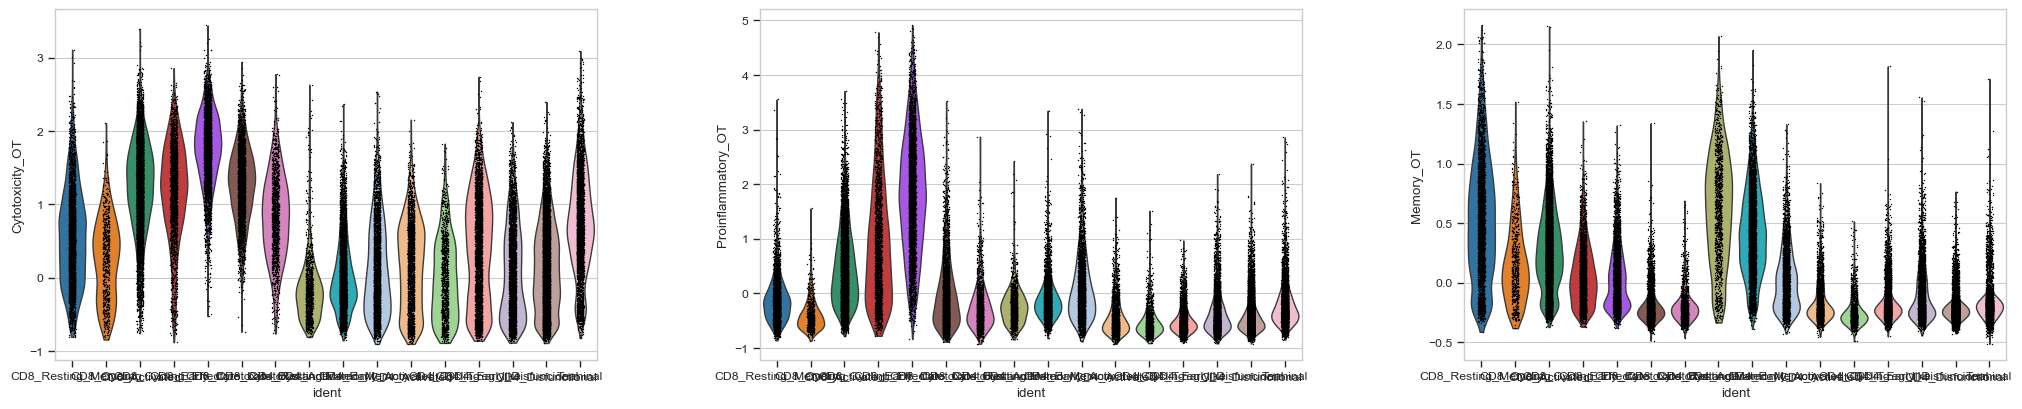

In [15]:
g=sc.pl.violin(all_adata, groupby="ident", keys=["Cytotoxicity_OT", "Proinflammatory_OT", "Memory_OT"])


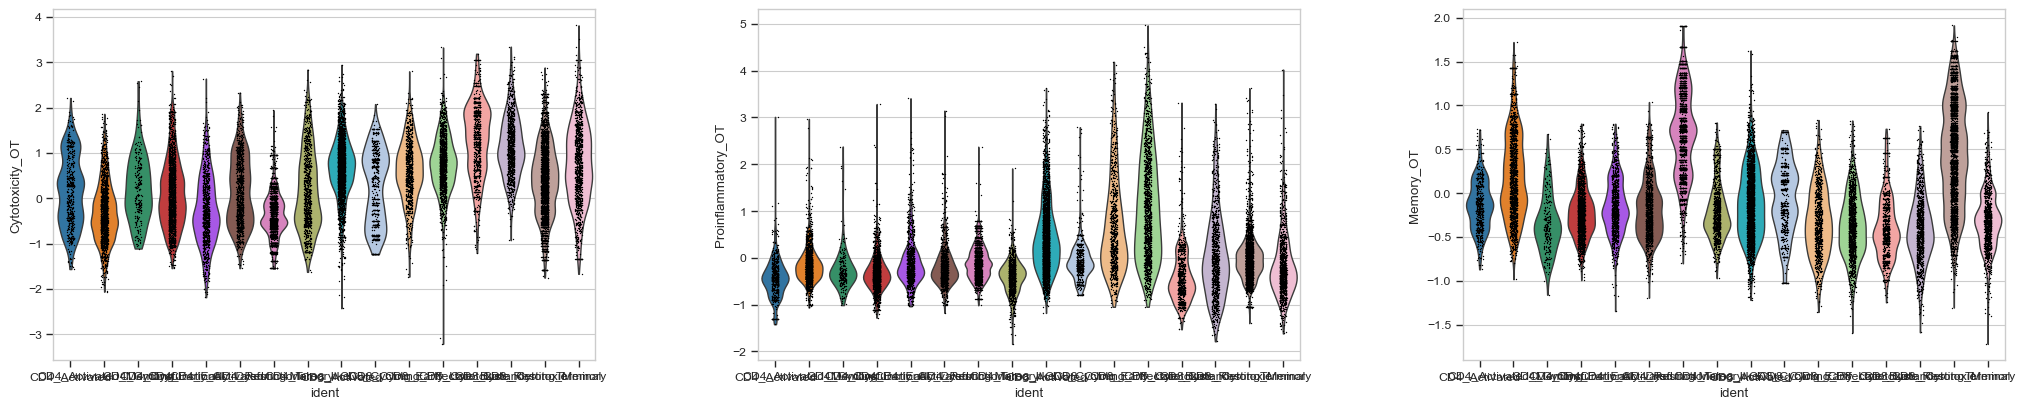

In [16]:
g = sc.pl.violin(adata, groupby="ident", keys=["Cytotoxicity_OT", "Proinflammatory_OT", "Memory_OT"])

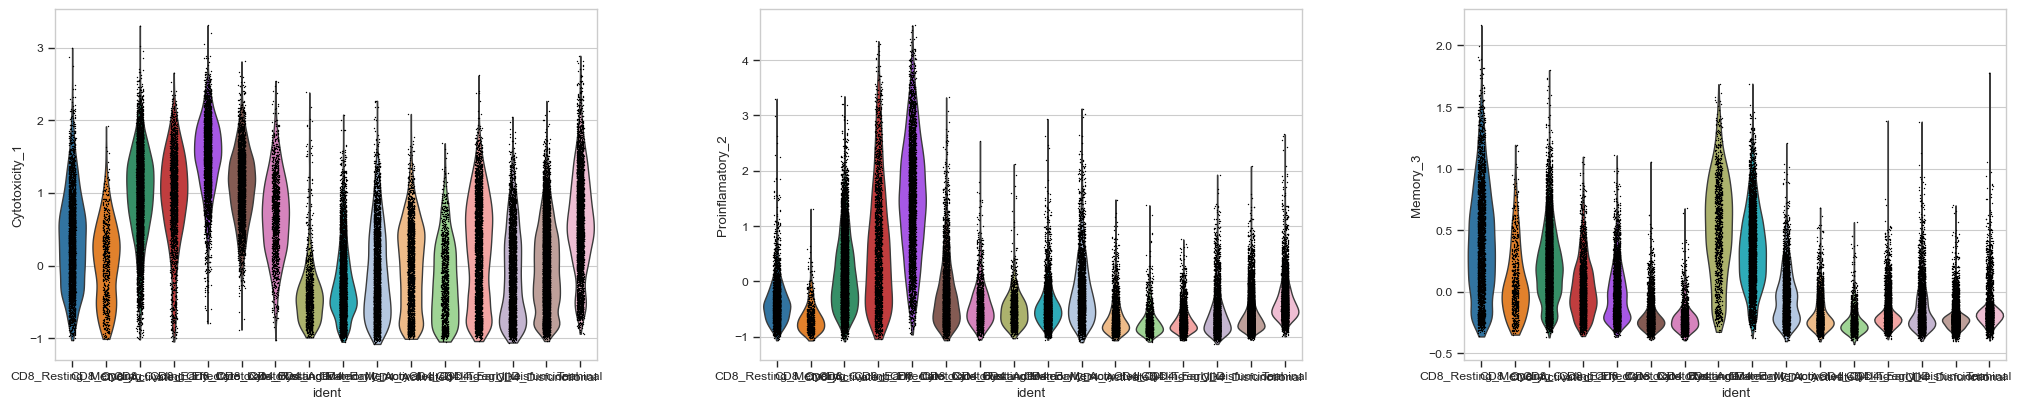

In [17]:
sc.pl.violin(all_adata, groupby="ident", keys=["Cytotoxicity_1", "Proinflamatory_2", "Memory_3"])

# Plot percentage pos

In [18]:
adata.obs["Cytox_pos"] = [s>1 for s in adata.obs["Cytotoxicity_OT"]]
adata.obs["Proinflam_pos"] = [s>1 for s in adata.obs["Proinflammatory_OT"]]
adata.obs["Mem_pos"] = [s>0 for s in adata.obs["Memory_OT"]]

In [19]:
adata.obs.loc[(adata.obs["subset"]=="CD4")&(adata.obs["CAR_Variant"].isin(sel_cars["CD4"])), "ID"] = True
adata.obs.loc[(adata.obs["subset"]=="CD4")&~(adata.obs["CAR_Variant"].isin(sel_cars["CD4"])), "ID"] = False

adata.obs.loc[(adata.obs["subset"]=="CD8")&(adata.obs["CAR_Variant"].isin(sel_cars["CD8"])), "ID"] = True
adata.obs.loc[(adata.obs["subset"]=="CD8")&~(adata.obs["CAR_Variant"].isin(sel_cars["CD8"])), "ID"] = False
adata.obs["ID"] = adata.obs["ID"].astype(bool)
adata.obs["OOD"] = ~adata.obs["ID"]

In [20]:
pos_counts = adata[adata.obs["subset"]=="CD8"].obs.groupby(["CAR_Variant", "dtype", "ID", "OOD"], observed=True).sum(numeric_only=True)[["Cytox_pos", "Proinflam_pos", "Mem_pos"]]
tot = adata.obs.groupby(["CAR_Variant", "dtype"], observed=True).size()
pos_counts["total"] = tot
pos_counts["cytox_perc"] = pos_counts["Cytox_pos"] / pos_counts["total"] * 100
pos_counts["proinf_perc"] = pos_counts["Proinflam_pos"] / pos_counts["total"] * 100
pos_counts["mem_perc"] = pos_counts["Mem_pos"] / pos_counts["total"] * 100
pos_counts = pos_counts.reset_index()
pos_counts = pos_counts[~pos_counts["CAR_Variant"].isin(["NA-NA-NA", "NA-NA-z"])]
pos_counts["CAR_Variant"] = pos_counts["CAR_Variant"].astype(str)
pos_counts["dtype"] = pos_counts["dtype"].astype(str)

In [21]:
tot

CAR_Variant      dtype    
41BB-41BB-z      target        308
                 transport     308
41BB-CD28-z      target        296
                 transport     296
41BB-CD40-z      target        245
                              ... 
IL15RA-IL15RA-z  target        273
                 transport     273
IL15RA-NA-z      target        382
                 transport     382
NA-NA-NA         source       7820
Length: 61, dtype: int64

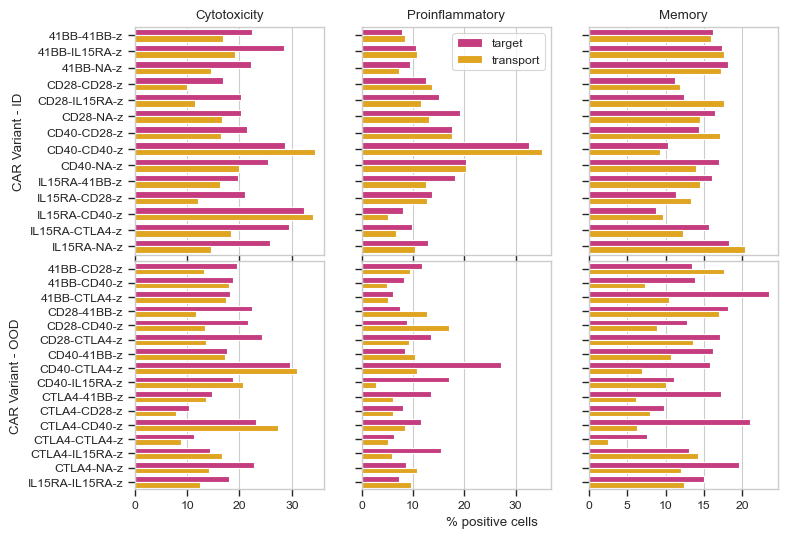

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(8.3, 6), sharey='row', sharex='col')
flat_axes= axes.flat
sns.barplot(data=pos_counts[pos_counts["ID"]], x="cytox_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[0])
sns.barplot(data=pos_counts[pos_counts["ID"]], x="proinf_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[1])
sns.barplot(data=pos_counts[pos_counts["ID"]], x="mem_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[2])

sns.barplot(data=pos_counts[pos_counts["OOD"]], x="cytox_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[3])
sns.barplot(data=pos_counts[pos_counts["OOD"]], x="proinf_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[4])
sns.barplot(data=pos_counts[pos_counts["OOD"]], x="mem_perc", y="CAR_Variant", hue="dtype", palette=ot_map, ax=flat_axes[5])


flat_axes[0].legend([],[], frameon=False)
flat_axes[2].legend([],[], frameon=False)
flat_axes[3].legend([],[], frameon=False)
flat_axes[4].legend([],[], frameon=False)
flat_axes[5].legend([],[], frameon=False)
flat_axes[1].legend(title="")

flat_axes[0].set_title("Cytotoxicity")
flat_axes[1].set_title("Proinflammatory")
flat_axes[2].set_title("Memory")

flat_axes[0].set_xlabel("")
flat_axes[1].set_xlabel("")
flat_axes[2].set_xlabel("")
flat_axes[3].set_xlabel("")
flat_axes[4].set_xlabel("")
flat_axes[5].set_xlabel("")

flat_axes[0].set_ylabel("CAR Variant - ID")
flat_axes[3].set_ylabel("CAR Variant - OOD")

fig.text(0.5, 0.05, "% positive cells")
fig.subplots_adjust(hspace=0.03)

plt.savefig(f"{base_fig_save}percentage_pos_score.pdf", bbox_inches="tight")


In [23]:
pos_counts["ID_OOD"] = ["ID" if ID else "OOD" for ID in pos_counts["ID"]]
temp = pos_counts[["CAR_Variant", "dtype", "ID_OOD", "cytox_perc", "proinf_perc", "mem_perc"]].set_index(["CAR_Variant"])
transport = temp.loc[temp["dtype"]=='transport', ["ID_OOD", "cytox_perc", "proinf_perc", "mem_perc"]]
target = temp.loc[temp["dtype"]=='target', ["cytox_perc", "proinf_perc", "mem_perc"]]
plt_data = transport.merge(target, left_index=True, right_index=True, suffixes=("_transport", "_target")).reset_index(drop=False)

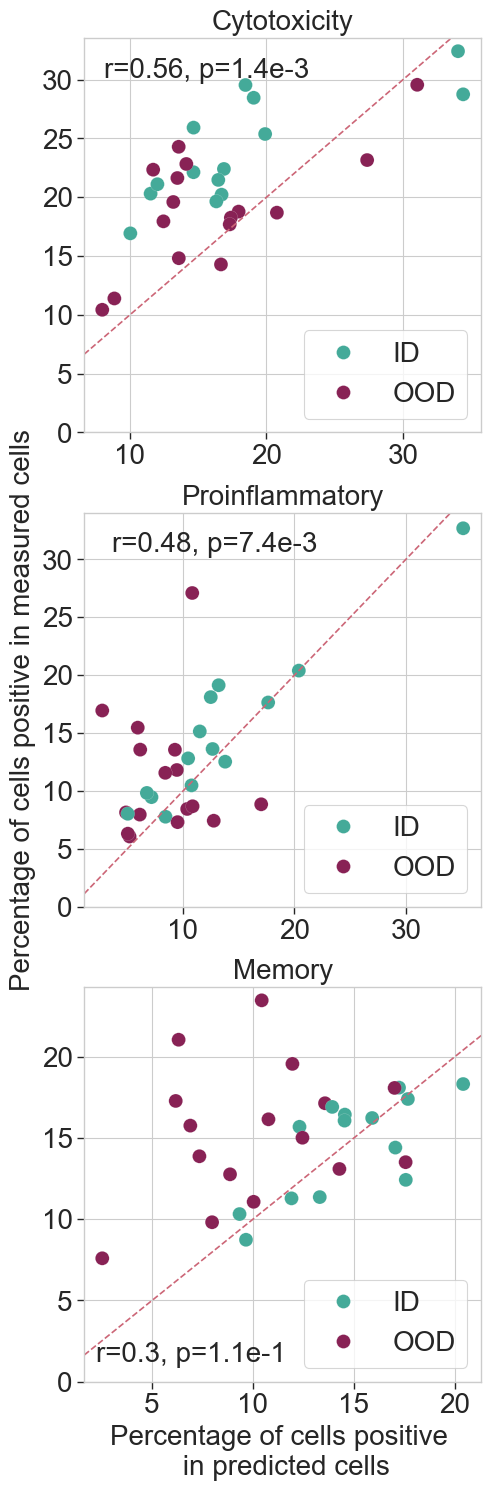

In [39]:
ID_OOD_map = {"ID": default_colors["teal"], "OOD": default_colors["wine"]}

scores=["Cytotoxicity", "Proinflammatory", "Memory"]
score_labels=["cytox_perc", "proinf_perc", "mem_perc"]

fig, axes = plt.subplots(3,1,sharex=False, sharey=False, figsize=(5,15))


for i, score in enumerate(scores):
    score_label = score_labels[i]
    spearman = round(spearmanr(plt_data[[f"{score_label}_transport", f"{score_label}_target"]]).statistic, 2)
    pval = Decimal(spearmanr(plt_data[[f"{score_label}_transport", f"{score_label}_target"]]).pvalue)
    pval = '{:.1e}'.format(pval)
    g = sns.scatterplot(data=plt_data, x=f"{score_label}_transport", y=f"{score_label}_target", hue="ID_OOD", 
                        palette=ID_OOD_map, ax=axes[i], s=100, linewidth=0.1)
    axes[i].legend(fontsize=20, title_fontsize=20, loc="lower right")
    axes[i].set_ylim((0,None))
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(score, fontsize=20)
    axes[i].axline(slope=1, xy1=(12,12), linestyle="--", color=default_colors["rose"])
    axes[i].tick_params(which="both", axis="both", labelsize=20)
    if i==0:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.05, 0.90), xycoords="axes fraction", fontsize=20)
    elif i==1:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.07, 0.90), xycoords="axes fraction", fontsize=20)
    elif i==2:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.03, 0.05), xycoords="axes fraction", fontsize=20)
fig.subplots_adjust(wspace=0.05)
axes[2].set_xlabel("Percentage of cells positive \n in predicted cells", fontsize=20)
axes[1].set_ylabel("Percentage of cells positive in measured cells", fontsize=20)
plt.tight_layout()
plt.savefig(f"{base_fig_save}percentage_pos_score_scatter_vertical.pdf", bbox_inches="tight")
plt.show()


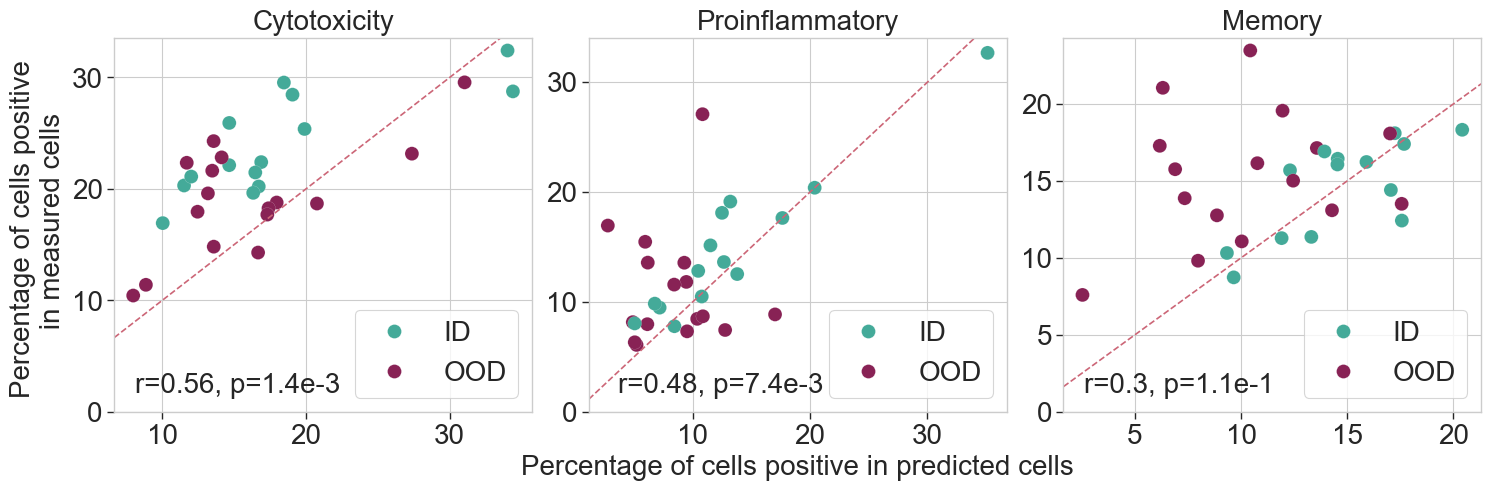

In [40]:
ID_OOD_map = {"ID": default_colors["teal"], "OOD": default_colors["wine"]}

scores=["Cytotoxicity", "Proinflammatory", "Memory"]
score_labels=["cytox_perc", "proinf_perc", "mem_perc"]

fig, axes = plt.subplots(1, 3,sharex=False, sharey=False, figsize=(15,5))


for i, score in enumerate(scores):
    score_label = score_labels[i]
    spearman = round(spearmanr(plt_data[[f"{score_label}_transport", f"{score_label}_target"]]).statistic, 2)
    pval = Decimal(spearmanr(plt_data[[f"{score_label}_transport", f"{score_label}_target"]]).pvalue)
    pval = '{:.1e}'.format(pval)
    g = sns.scatterplot(data=plt_data, x=f"{score_label}_transport", y=f"{score_label}_target", hue="ID_OOD", 
                        palette=ID_OOD_map, ax=axes[i], s=100, linewidth=0.1)
    axes[i].legend(fontsize=20, title_fontsize=20, loc="lower right")
    axes[i].set_ylim((0,None))
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(score, fontsize=20)
    axes[i].axline(slope=1, xy1=(12,12), linestyle="--", color=default_colors["rose"])
    axes[i].tick_params(which="both", axis="both", labelsize=20)
    if i==0:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.05, 0.05), xycoords="axes fraction", fontsize=20)
    elif i==1:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.07, 0.05), xycoords="axes fraction", fontsize=20)
    elif i==2:
        axes[i].annotate(f"r={spearman}, p={pval}", xy=(0.05, 0.05), xycoords="axes fraction", fontsize=20)
fig.subplots_adjust(wspace=0.05)
axes[1].set_xlabel("Percentage of cells positive in predicted cells", fontsize=20)
axes[0].set_ylabel("Percentage of cells positive \n in measured cells", fontsize=20)
plt.tight_layout()
plt.savefig(f"{base_fig_save}percentage_pos_score_scatter.pdf", bbox_inches="tight")
plt.show()


# Cell type distribution

In [26]:
with open("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/celltype_models/20240229_from_rocio_for_manuscript_FuncScore_genes_svm.pkl", "rb") as f:
   celltyper = pickle.load(f)

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.5.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [27]:
adata.obs["pred_celltype"] = celltyper.predict(adata.X)
adata.obs.loc[adata.obs['pred_celltype']=="CD4_Disfunctional", "pred_celltype"] = "CD4_Dysfunctional"
adata.obs.loc[adata.obs['pred_celltype']=="CD4_Early_Disfuncional", "pred_celltype"] = "CD4_Early_Dysfunctional"

In [28]:
plt_data1 = adata[(adata.obs["dtype"]=="transport")].obs.groupby(["CAR_Variant", "pred_celltype"]).size().reset_index().rename(columns={0:"count"})
plt_data1_tot = adata[(adata.obs["dtype"]=="transport")].obs.groupby(["CAR_Variant"]).size().reset_index().rename(columns={0:"total"})
plt_data1 = plt_data1.merge(plt_data1_tot, on="CAR_Variant", how="left")
plt_data1["celltype_frac"] = plt_data1["count"]/plt_data1["total"]
plt_data1 = plt_data1.pivot_table(index="CAR_Variant", columns="pred_celltype", values="celltype_frac")

plt_data2 = adata[(adata.obs["dtype"]=="target")].obs.groupby(["CAR_Variant", "pred_celltype"]).size().reset_index().rename(columns={0:"count"})
plt_data2_tot = adata[(adata.obs["dtype"]=="target")].obs.groupby(["CAR_Variant"]).size().reset_index().rename(columns={0:"total"})
plt_data2 = plt_data2.merge(plt_data2_tot, on="CAR_Variant", how="left")
plt_data2["celltype_frac"] = plt_data2["count"]/plt_data2["total"]
plt_data2 = plt_data2.pivot_table(index="CAR_Variant", columns="pred_celltype", values="celltype_frac")

anno = adata.obs[["subset", "CAR_Variant", "ID"]].drop_duplicates()
anno = anno.pivot_table(index="CAR_Variant", columns="subset", values="ID")
anno[["CD4", "CD8"]] = anno[["CD4", "CD8"]].astype(bool)
anno.columns = ["CD4", "CD8"]
anno=anno.loc[anno.index!="NA-NA-NA"]

# plt_data3 = adata[adata.obs["dtype"]=="source"].obs.groupby(["CAR_Variant", "pred_celltype"]).size().reset_index().rename(columns={0:"count"})
# plt_data3_tot = adata[adata.obs["dtype"]=="source"].obs.groupby(["CAR_Variant"]).size().reset_index().rename(columns={0:"total"})
# plt_data3 = plt_data3.merge(plt_data3_tot, on="CAR_Variant", how="left")
# plt_data3["celltype_frac"] = plt_data3["count"]/plt_data3["total"]
# plt_data3 = plt_data3.pivot_table(index="CAR_Variant", columns="pred_celltype", values="celltype_frac")

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_1567/2382538360.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plt_data1 = adata[(adata.obs["dtype"]=="transport")].obs.groupby(["CAR_Variant", "pred_celltype"]).size().reset_index().rename(columns={0:"count"})
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_1567/2382538360.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plt_data1_tot = adata[(adata.obs["dtype"]=="transport")].obs.groupby(["CAR_Variant"]).size().reset_index().rename(columns={0:"total"})
/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_1567/2382538360.py:5

In [29]:
myColors = (default_colors['wine'], default_colors['teal'])
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

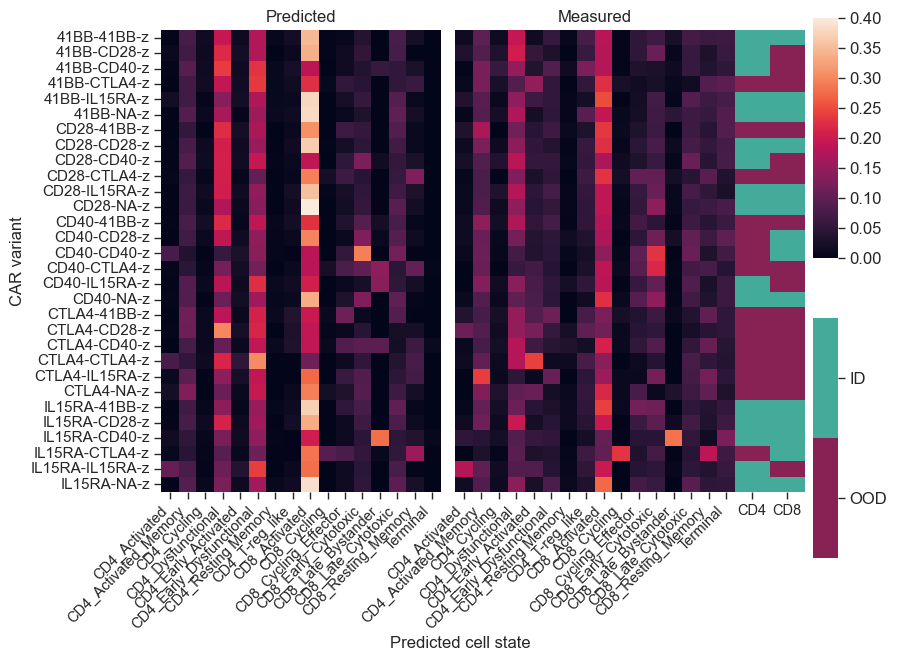

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(8.3, 6), sharey="row", sharex="col", width_ratios=[4,0.2,4,1])
cbar_ax= fig.add_axes([0.91, 0.0, 0.03, 0.4])
cbar_ax2= fig.add_axes([0.91, 0.5, 0.03, 0.4])

sns.heatmap(data=plt_data1, ax=axes[0], vmin=0, vmax=0.4, cbar_ax=cbar_ax2)
sns.heatmap(data=plt_data2, ax=axes[2], vmin=0, vmax=0.4, cbar_ax=cbar_ax2)
sns.heatmap(data=anno, ax=axes[3], cbar_ax=cbar_ax, cmap=cmap)

axes[1].set_visible(False)

axes[0].set_title("Predicted", size=12)
axes[2].set_title("Measured", size=12)

axes[0].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("CAR variant", size=12)
axes[2].set_ylabel("")
axes[3].set_ylabel("")

axes[0].set_yticks(axes[0].get_yticks(), axes[0].get_yticklabels(), size=11)
axes[0].set_xticks(axes[0].get_xticks(), axes[0].get_xticklabels(), rotation=45, ha="right", size=10.5)
axes[2].set_xticks(axes[2].get_xticks(), axes[2].get_xticklabels(), rotation=45, ha="right", size=10.5)
axes[3].set_xticks(axes[3].get_xticks(), axes[3].get_xticklabels(), size=10.5)
cbar_ax2.set_yticks(cbar_ax2.get_yticks(), cbar_ax2.get_yticklabels(), size=12)

axes[2].tick_params(which="both", axis="y",left=False)
axes[3].tick_params(which="both", axis="y",left=False)

cbar_ax.set_yticks([0.25, 0.75])
cbar_ax.set_yticklabels(["OOD", "ID"], size=12)

fig.text(0.4, -0.15, "Predicted cell state", size=12)
fig.subplots_adjust(wspace=0)
plt.savefig(f"{base_fig_save}celltype_comparison.pdf", bbox_inches="tight")


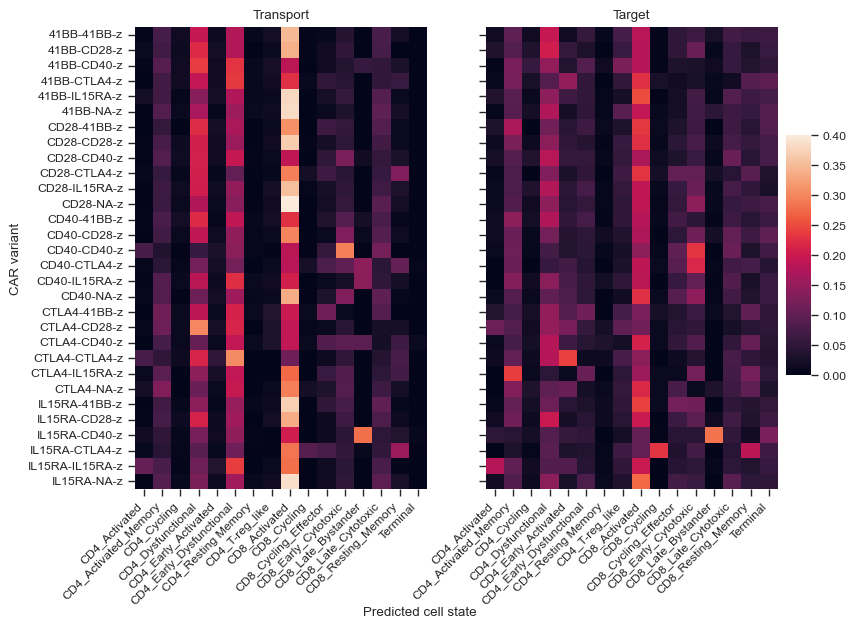

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(8.3, 6), sharey="row", sharex="col")
cbar_ax= fig.add_axes([0.91, 0.3, 0.03, 0.4])

sns.heatmap(data=plt_data1, ax=axes[0], vmin=0, vmax=0.4, cbar_ax=cbar_ax)
sns.heatmap(data=plt_data2, ax=axes[1], vmin=0, vmax=0.4, cbar_ax=cbar_ax)

axes[0].set_title("Transport")
axes[1].set_title("Target")

axes[0].set_xlabel("")
axes[1].set_xlabel("")

axes[0].set_ylabel("CAR variant")
axes[1].set_ylabel("")
fig.text(0.4, -0.1, "Predicted cell state")

axes[0].set_xticks(axes[0].get_xticks(), axes[0].get_xticklabels(), rotation=45, ha="right")
axes[1].set_xticks(axes[1].get_xticks(), axes[1].get_xticklabels(), rotation=45, ha="right")

# plt.savefig(f"{base_fig_save}celltype_comparison.pdf", bbox_inches="tight")


In [32]:
anno = adata.obs[["subset", "CAR_Variant", "ID"]].drop_duplicates()
anno = anno.pivot_table(index="CAR_Variant", columns="subset", values="ID")
anno[["CD4", "CD8"]] = anno[["CD4", "CD8"]].astype(bool)
anno.columns = ["CD4 - ID", "CD8 - ID"]
anno

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_1567/3763293242.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  anno = anno.pivot_table(index="CAR_Variant", columns="subset", values="ID")


CD4 - ID  CD8 - ID
CAR_Variant                        
41BB-41BB-z          True      True
41BB-CD28-z          True     False
41BB-CD40-z          True     False
41BB-CTLA4-z        False     False
41BB-IL15RA-z        True      True
41BB-NA-z            True      True
CD28-41BB-z         False     False
CD28-CD28-z          True      True
CD28-CD40-z          True     False
CD28-CTLA4-z        False     False
CD28-IL15RA-z        True      True
CD28-NA-z            True      True
CD40-41BB-z         False     False
CD40-CD28-z         False      True
CD40-CD40-z         False      True
CD40-CTLA4-z        False     False
CD40-IL15RA-z        True     False
CD40-NA-z            True      True
CTLA4-41BB-z        False     False
CTLA4-CD28-z        False     False
CTLA4-CD40-z        False     False
CTLA4-CTLA4-z       False     False
CTLA4-IL15RA-z      False     False
CTLA4-NA-z          False     False
IL15RA-41BB-z        True      True
IL15RA-CD28-z        True      True
IL15RA-CD40-z        True      True
IL15RA-CTLA4-z      False      True
IL15RA-IL15RA-z      True     False
IL15RA-NA-z          True      True
NA-NA-NA            False     False

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [34]:
temp = cosine_similarity(plt_data1.T, plt_data2.T)

In [35]:
temp.shape

(16, 16)

In [36]:
pd.DataFrame(temp, index=pd.Series(plt_data1.columns, name="Target"), columns=pd.Series(plt_data2.columns, name="Transport"))

Transport                CD4_Activated  CD4_Activated_Memory  CD4_Cycling  \
Target                                                                      
CD4_Activated                 0.658484              0.450388     0.345850   
CD4_Activated_Memory          0.557938              0.927210     0.875393   
CD4_Cycling                   0.436343              0.783325     0.858342   
CD4_Dysfunctional             0.544317              0.913719     0.843099   
CD4_Early_Activated           0.653168              0.858315     0.708849   
CD4_Early_Dysfunctional       0.591812              0.935545     0.866811   
CD4_Resting Memory            0.263594              0.639157     0.694503   
CD4_T-reg_like                0.523859              0.770619     0.823995   
CD8_Activated                 0.505451              0.902334     0.784113   
CD8_Cycling                   0.080584              0.261071     0.225313   
CD8_Cycling_Effector          0.330138              0.756776     0.595517   
CD8_Early_Cytotoxic           0.360508              0.783475     0.608310   
CD8_Late_Bystander            0.185786              0.307550     0.343597   
CD8_Late_Cytotoxic            0.502430              0.892934     0.765210   
CD8_Resting_Memory            0.186020              0.587676     0.427493   
Terminal                      0.136857              0.204882     0.233190   

Transport                CD4_Dysfunctional  CD4_Early_Activated  \
Target                                                            
CD4_Activated                     0.389757             0.592776   
CD4_Activated_Memory              0.929802             0.790564   
CD4_Cycling                       0.934583             0.735100   
CD4_Dysfunctional                 0.961729             0.799788   
CD4_Early_Activated               0.818558             0.886901   
CD4_Early_Dysfunctional           0.940626             0.883566   
CD4_Resting Memory                0.719478             0.545277   
CD4_T-reg_like                    0.884491             0.681352   
CD8_Activated                     0.929170             0.690940   
CD8_Cycling                       0.311420             0.294597   
CD8_Cycling_Effector              0.704682             0.629398   
CD8_Early_Cytotoxic               0.712366             0.607642   
CD8_Late_Bystander                0.312812             0.309855   
CD8_Late_Cytotoxic                0.901060             0.688454   
CD8_Resting_Memory                0.575225             0.572874   
Terminal                          0.286437             0.254816   

Transport                CD4_Early_Dysfunctional  CD4_Resting Memory  \
Target                                                                 
CD4_Activated                           0.335063            0.336882   
CD4_Activated_Memory                    0.925916            0.742530   
CD4_Cycling                             0.827287            0.673827   
CD4_Dysfunctional                       0.905187            0.727748   
CD4_Early_Activated                     0.779176            0.654396   
CD4_Early_Dysfunctional                 0.902577            0.759111   
CD4_Resting Memory                      0.749548            0.613873   
CD4_T-reg_like                          0.861784            0.770979   
CD8_Activated                           0.889034            0.658606   
CD8_Cycling                             0.313175            0.229540   
CD8_Cycling_Effector                    0.805020            0.515439   
CD8_Early_Cytotoxic                     0.709751            0.605077   
CD8_Late_Bystander                      0.346570            0.326855   
CD8_Late_Cytotoxic                      0.886689            0.623884   
CD8_Resting_Memory                      0.586283            0.433622   
Terminal                                0.254048            0.409104   

Transport                CD4_T-reg_like  CD8_Activated  CD8_Cycling  \
Target                                

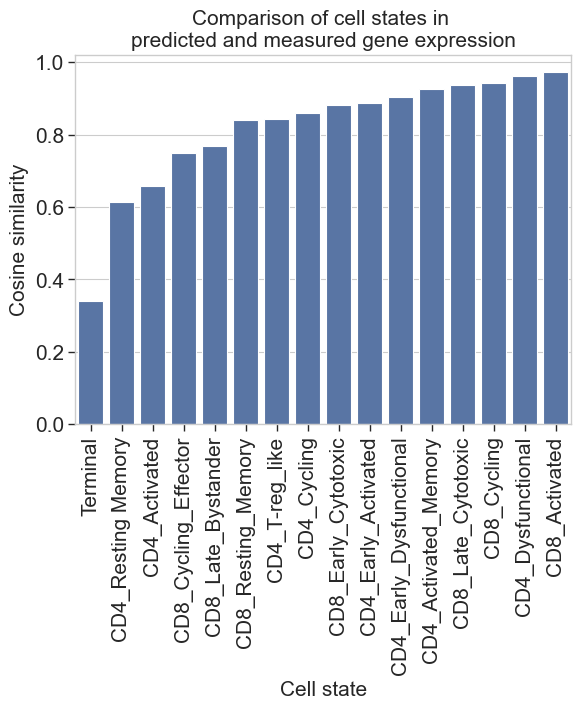

In [37]:
sns.barplot(pd.Series(np.diagonal(temp), index=plt_data1.columns).sort_values())
t = plt.xticks(rotation=90, fontsize=15)
t = plt.yticks(fontsize=15)
t = plt.xlabel("Cell state", fontsize=15)
t = plt.ylabel("Cosine similarity", fontsize=15)
t = plt.title("Comparison of cell states in \npredicted and measured gene expression", fontsize=15)
plt.savefig(f"{base_fig_save}cellstate_prediction_quality.pdf", bbox_inches="tight")


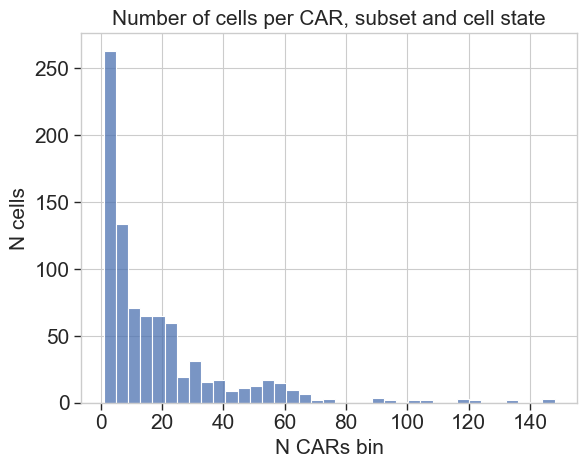

In [38]:
t = adata.obs.groupby(["CAR_Variant", "dtype", "pred_celltype"], observed=True).size().sort_values().reset_index()
t = t[t["CAR_Variant"]!="NA-NA-NA"]
sns.histplot(t[0])
p = plt.xticks(fontsize=15)
p = plt.yticks(fontsize=15)
p = plt.xlabel("N CARs bin", fontsize=15)
p = plt.ylabel("N cells", fontsize=15)
p = plt.title("Number of cells per CAR, subset and cell state", fontsize=15)
plt.savefig(f"{base_fig_save}cellstate_subset_car_count.pdf", bbox_inches="tight")
